In [134]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [135]:
!pip uninstall -y google-generativeai google-cloud-aiplatform google-api-core google
!pip install --upgrade pip setuptools
!pip install google-generativeai

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
Found existing installation: google-api-core 2.24.2
Uninstalling google-api-core-2.24.2:
  Successfully uninstalled google-api-core-2.24.2


  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
Using cached setuptools-80.3.1-py3-none-any.whl (1.2 MB)


ERROR: To modify pip, please run the following command:
C:\Users\brian\anaconda3\python.exe -m pip install --upgrade pip setuptools


  Using cached google_generativeai-0.8.5-py3-none-any.whl.metadata (3.9 kB)
  Using cached google_api_core-2.24.2-py3-none-any.whl.metadata (3.0 kB)
Using cached google_generativeai-0.8.5-py3-none-any.whl (155 kB)
Using cached google_api_core-2.24.2-py3-none-any.whl (160 kB)


# Data Cleaning

In [136]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [137]:
COLOR_WORDS = {
    'red', 'green', 'blue', 'yellow', 'black', 'white', 'pink', 'orange', 'purple', 'brown',
    'grey', 'gray', 'ivory', 'beige', 'silver', 'gold', 'multi', 'navy', 'lime', 'turquoise'
}

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_description(desc):
    # Convert description to lowercase
    desc = desc.lower()

    # Remove numbers
    desc = re.sub(r'\d+', '', desc)

    # Remove punctuation/special characters
    desc = re.sub(r'[^\w\s]', '', desc)

    words = desc.split()

    # Remove color words
    words = [word for word in words if word not in COLOR_WORDS]

    # Remove stopwords
    words = [word for word in words if word not in STOPWORDS]

    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [138]:
df = pd.read_json("../dataset/online_retail.json")
descriptions = set(df['Description'])

In [139]:
cleaned_descriptions = []

for description in descriptions:
    cleaned = clean_description(description)
    cleaned_descriptions.append(cleaned)

In [140]:
description_df = pd.DataFrame({
    'Description': list(descriptions),
    "Cleaned": cleaned_descriptions
})

# Clustering

In [141]:
import google.generativeai as genai
import json

In [142]:
with open('secrets.json') as f:
    secrets = json.load(f)

In [143]:
api_key = secrets['GEMINI_API_KEY']
genai.configure(api_key=api_key)

In [144]:
embeddings = [
    genai.embed_content(
        model="models/embedding-001",
        content=desc,
        task_type="semantic_similarity"
    )['embedding']
    for desc in description_df["Cleaned"]
]

In [145]:
description_df['Embedding'] = embeddings

In [146]:
description_df.to_csv("../dataset/descriptions.csv", index=False)


In [147]:
df = pd.read_json("../dataset/online_retail.json")
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate units sold by product and date
daily_sales = df.groupby(['Date', 'Description'])['UnitsSold'].sum().unstack(fill_value=0)

In [148]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
reduced = pca.fit_transform(embeddings)

In [149]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_reduced = reducer.fit_transform(embeddings)

c:\Users\brian\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# K-Means

In [150]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

In [151]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [152]:
# Full embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(embeddings)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(embeddings, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.0501
k=3, silhouette score=0.0522
k=4, silhouette score=0.0553
k=5, silhouette score=0.0615
k=6, silhouette score=0.0452
k=7, silhouette score=0.0682
k=8, silhouette score=0.0661
k=9, silhouette score=0.0789
k=10, silhouette score=0.0663
k=11, silhouette score=0.0886
k=12, silhouette score=0.0886
k=13, silhouette score=0.0851
k=14, silhouette score=0.0857
k=15, silhouette score=0.0968
k=16, silhouette score=0.1120
k=17, silhouette score=0.1145
k=18, silhouette score=0.1060
k=19, silhouette score=0.1201
k=20, silhouette score=0.1166
k=21, silhouette score=0.0990
k=22, silhouette score=0.1188
k=23, silhouette score=0.1170
k=24, silhouette score=0.1159
k=25, silhouette score=0.1217
k=26, silhouette score=0.1312
k=27, silhouette score=0.1136
k=28, silhouette score=0.1065
k=29, silhouette score=0.1079
k=30, silhouette score=0.1351


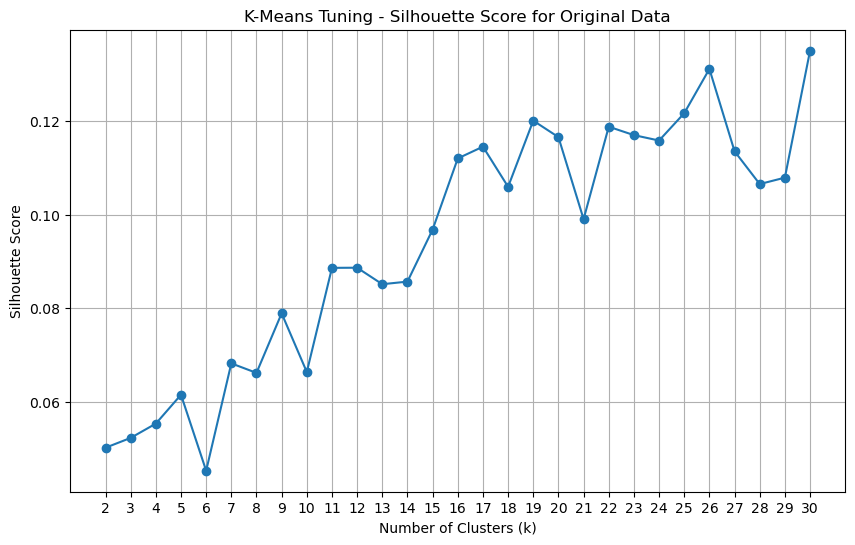

In [153]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, scores, marker='o')
plt.title('K-Means Tuning - Silhouette Score for Original Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

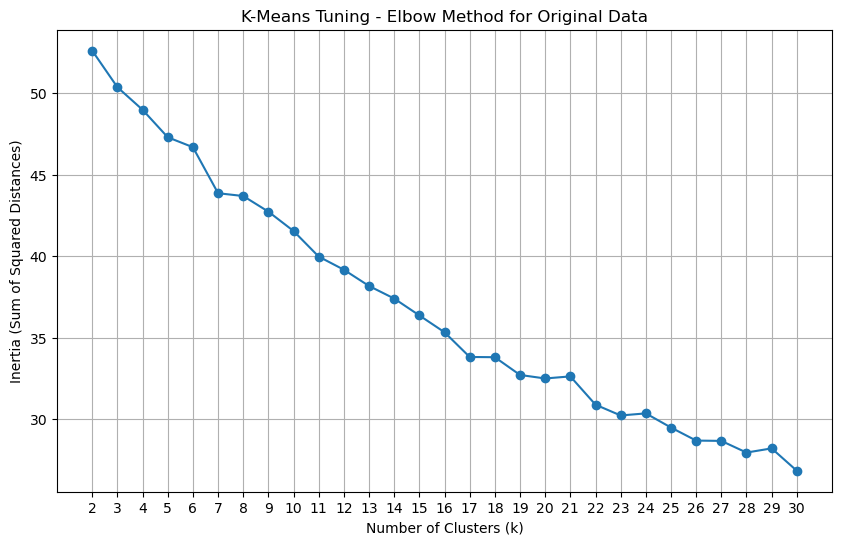

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('K-Means Tuning - Elbow Method for Original Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [155]:
# PCA Reduced Embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(reduced)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(reduced, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.1534
k=3, silhouette score=0.1592
k=4, silhouette score=0.1544
k=5, silhouette score=0.1751
k=6, silhouette score=0.1981
k=7, silhouette score=0.1867
k=8, silhouette score=0.2315
k=9, silhouette score=0.2301
k=10, silhouette score=0.2545
k=11, silhouette score=0.2639
k=12, silhouette score=0.2564
k=13, silhouette score=0.2650
k=14, silhouette score=0.2403
k=15, silhouette score=0.2630
k=16, silhouette score=0.2573
k=17, silhouette score=0.2639
k=18, silhouette score=0.2452
k=19, silhouette score=0.2557
k=20, silhouette score=0.2347
k=21, silhouette score=0.2361
k=22, silhouette score=0.2403
k=23, silhouette score=0.2192
k=24, silhouette score=0.2814
k=25, silhouette score=0.2330
k=26, silhouette score=0.2292
k=27, silhouette score=0.2552
k=28, silhouette score=0.2434
k=29, silhouette score=0.2536
k=30, silhouette score=0.2571


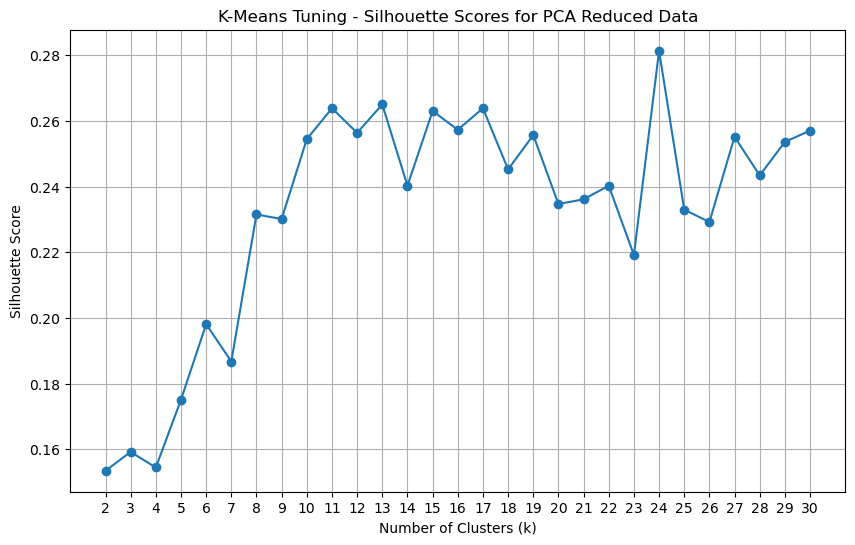

In [156]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, scores, marker='o')
plt.title('K-Means Tuning - Silhouette Scores for PCA Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

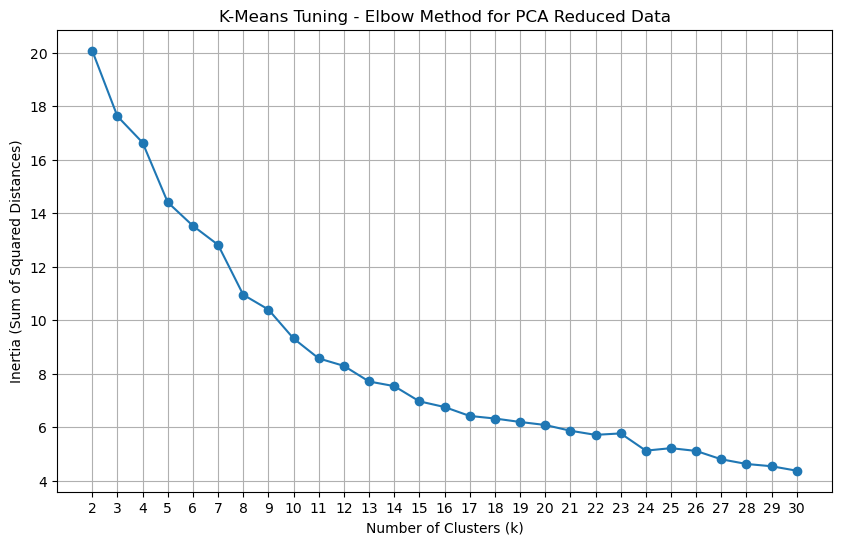

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('K-Means Tuning - Elbow Method for PCA Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [158]:
# UMAP Reduced Embeddings
cluster_values = list(range(2, 31))
scores = []
inertia_values = []

for n in cluster_values:
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(umap_reduced)
    inertia_values.append(kmeans.inertia_)
    score = silhouette_score(umap_reduced, labels)
    scores.append(score)
    print(f"k={n}, silhouette score={score:.4f}")

k=2, silhouette score=0.4054
k=3, silhouette score=0.4132
k=4, silhouette score=0.4187
k=5, silhouette score=0.4793
k=6, silhouette score=0.4936
k=7, silhouette score=0.4974
k=8, silhouette score=0.4747
k=9, silhouette score=0.4954
k=10, silhouette score=0.5055
k=11, silhouette score=0.4943
k=12, silhouette score=0.5032
k=13, silhouette score=0.5079
k=14, silhouette score=0.5175
k=15, silhouette score=0.5167
k=16, silhouette score=0.4690
k=17, silhouette score=0.4914
k=18, silhouette score=0.4977
k=19, silhouette score=0.4975
k=20, silhouette score=0.5193
k=21, silhouette score=0.5180
k=22, silhouette score=0.5217
k=23, silhouette score=0.4968
k=24, silhouette score=0.4884
k=25, silhouette score=0.5451
k=26, silhouette score=0.5299
k=27, silhouette score=0.5065
k=28, silhouette score=0.5291
k=29, silhouette score=0.4970
k=30, silhouette score=0.4799


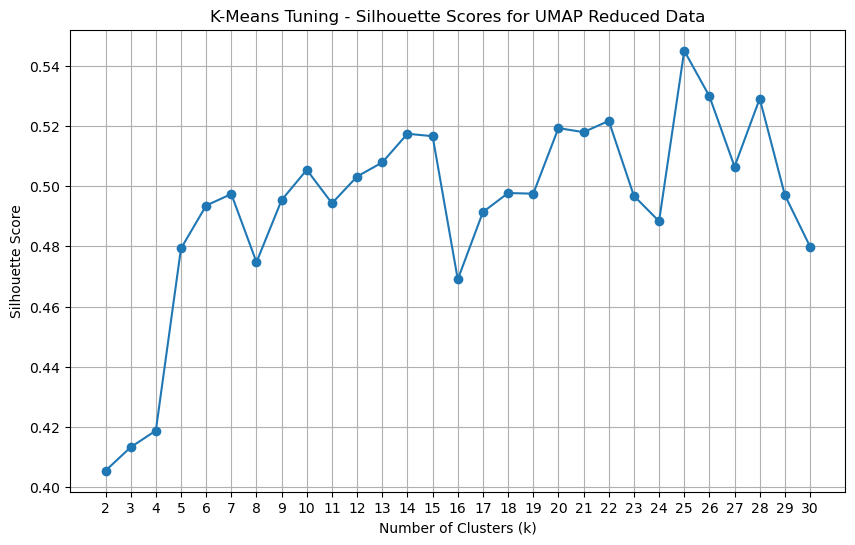

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, scores, marker='o')
plt.title('K-Means Tuning - Silhouette Scores for UMAP Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

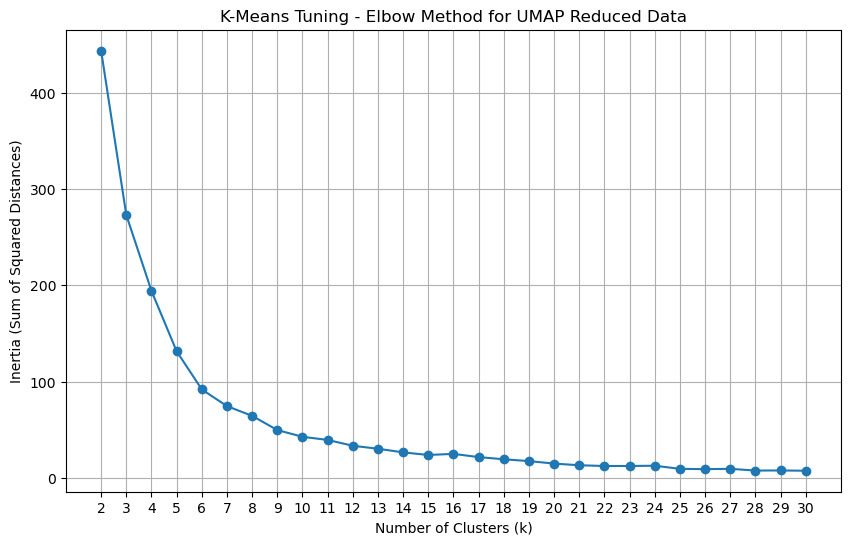

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_values, inertia_values, marker='o')
plt.title('K-Means Tuning - Elbow Method for UMAP Reduced Data')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_values)
plt.grid(True)
plt.show()

In [161]:
kmeans = KMeans(n_clusters=13)
labels = kmeans.fit_predict(umap_reduced)

In [162]:
description_df['K-Means_Cluster'] = labels

In [163]:
df = df.merge(
    description_df[['Description', 'K-Means_Cluster']],
    left_on='Description',
    right_on='Description',
    how='left'
)

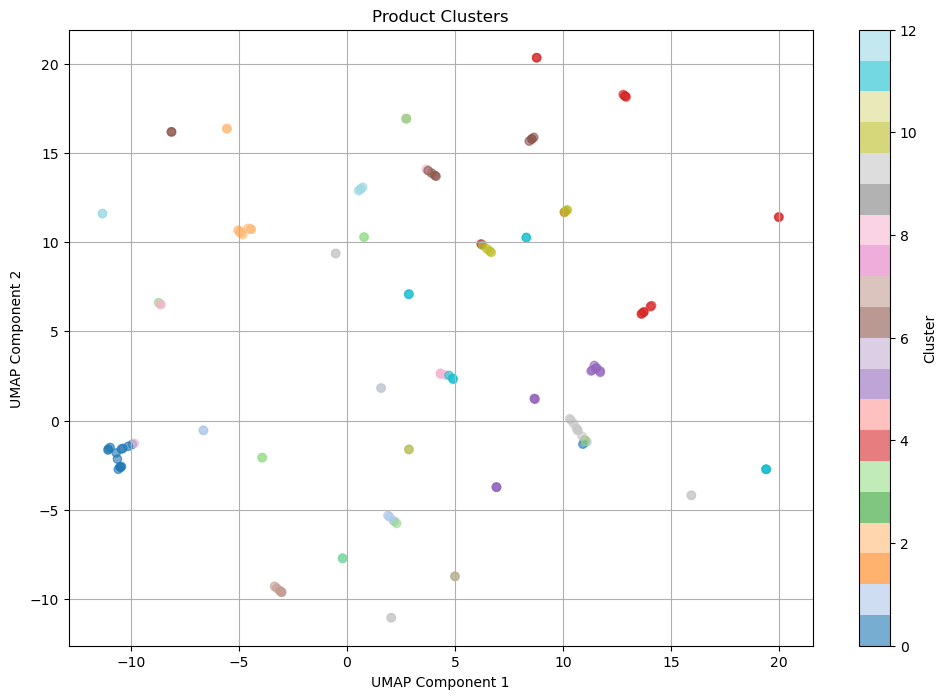

In [164]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['K-Means_Cluster'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

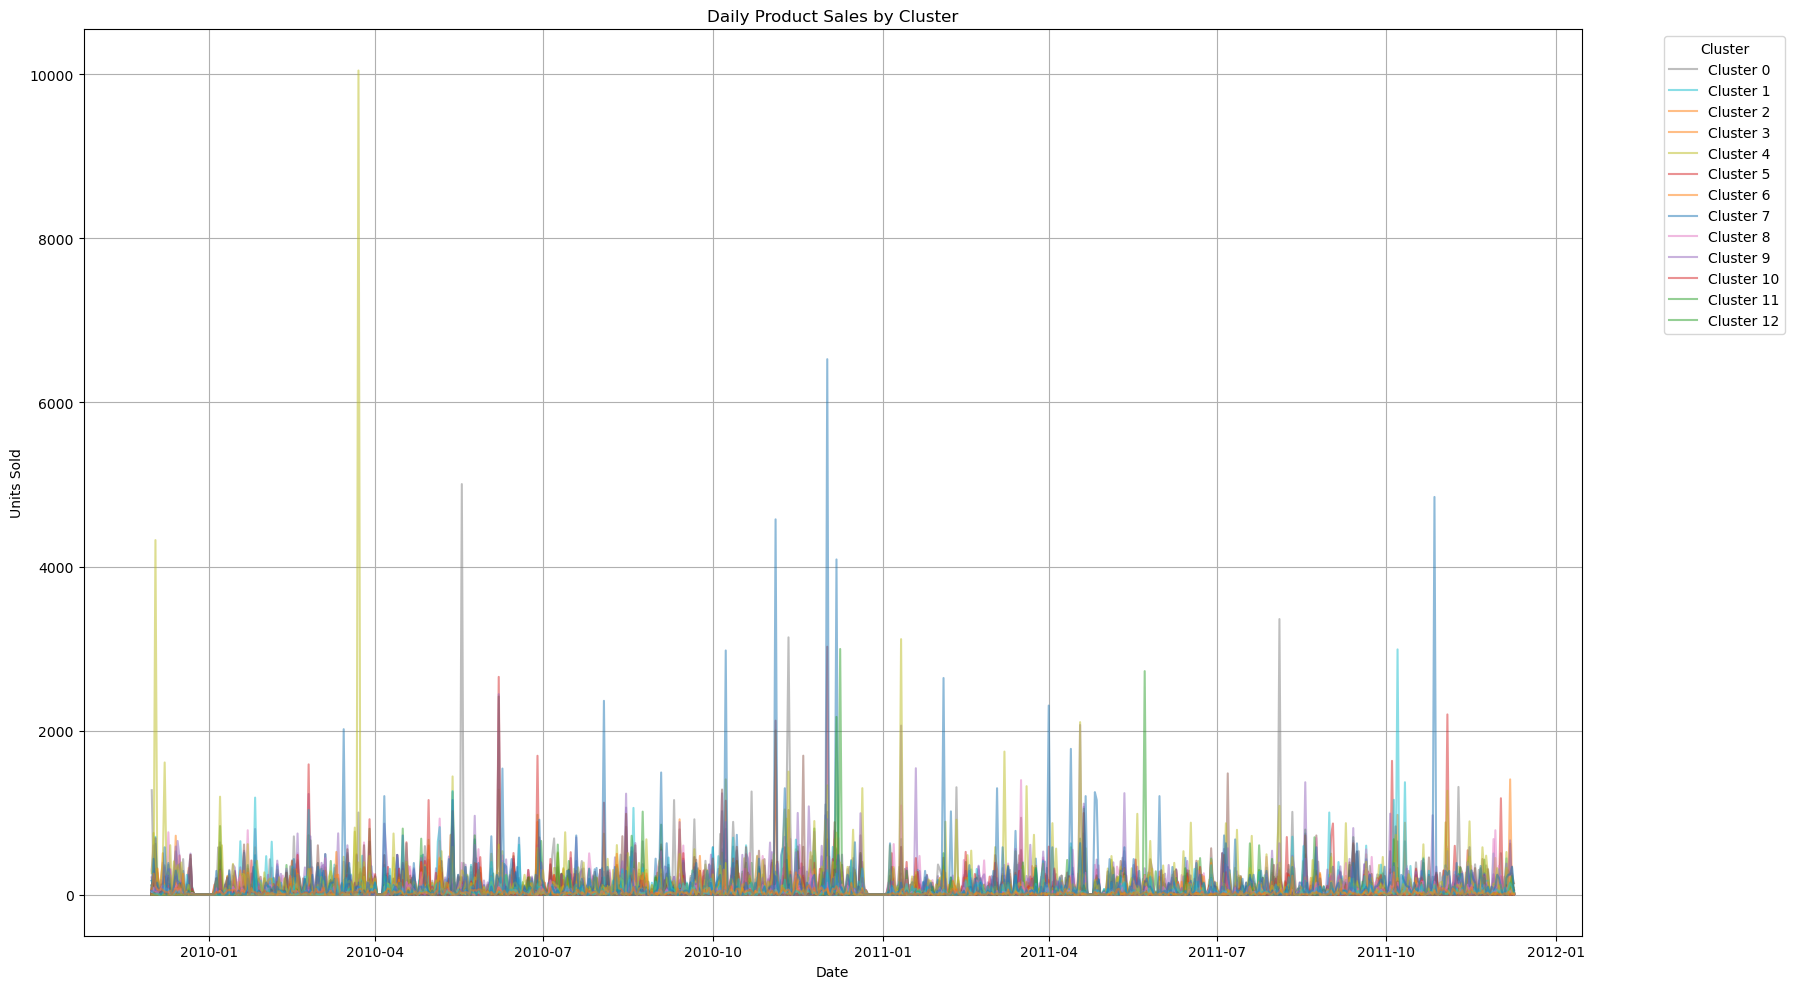

In [165]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'K-Means_Cluster'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

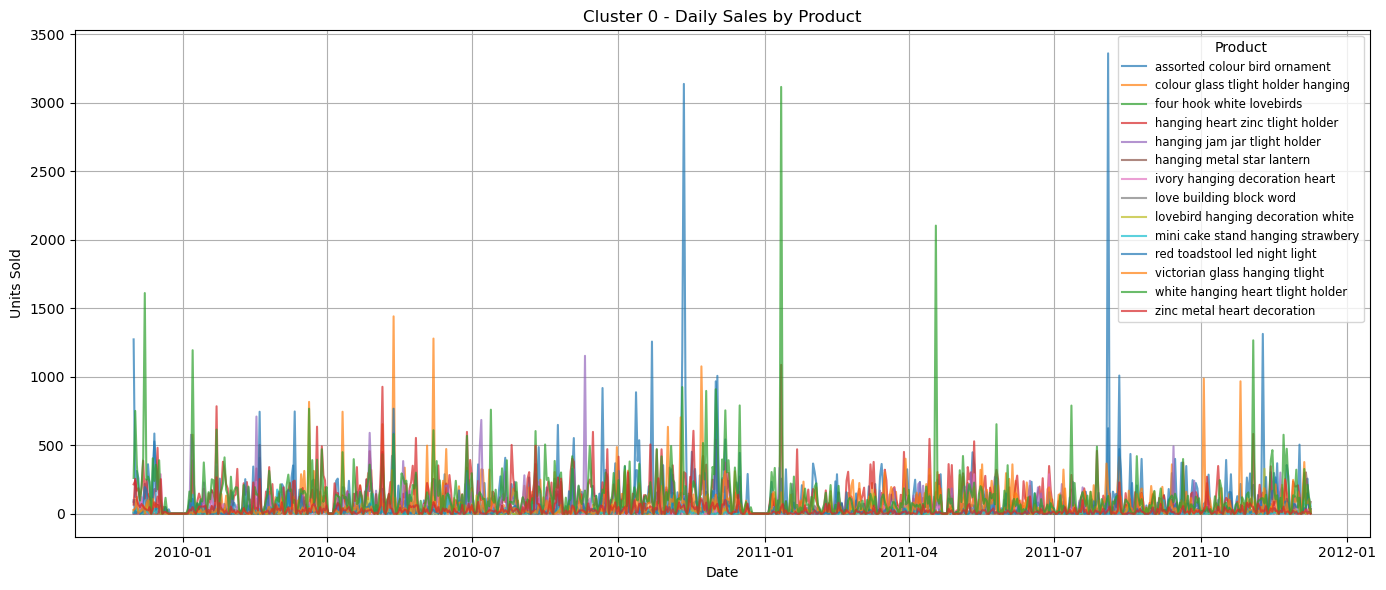

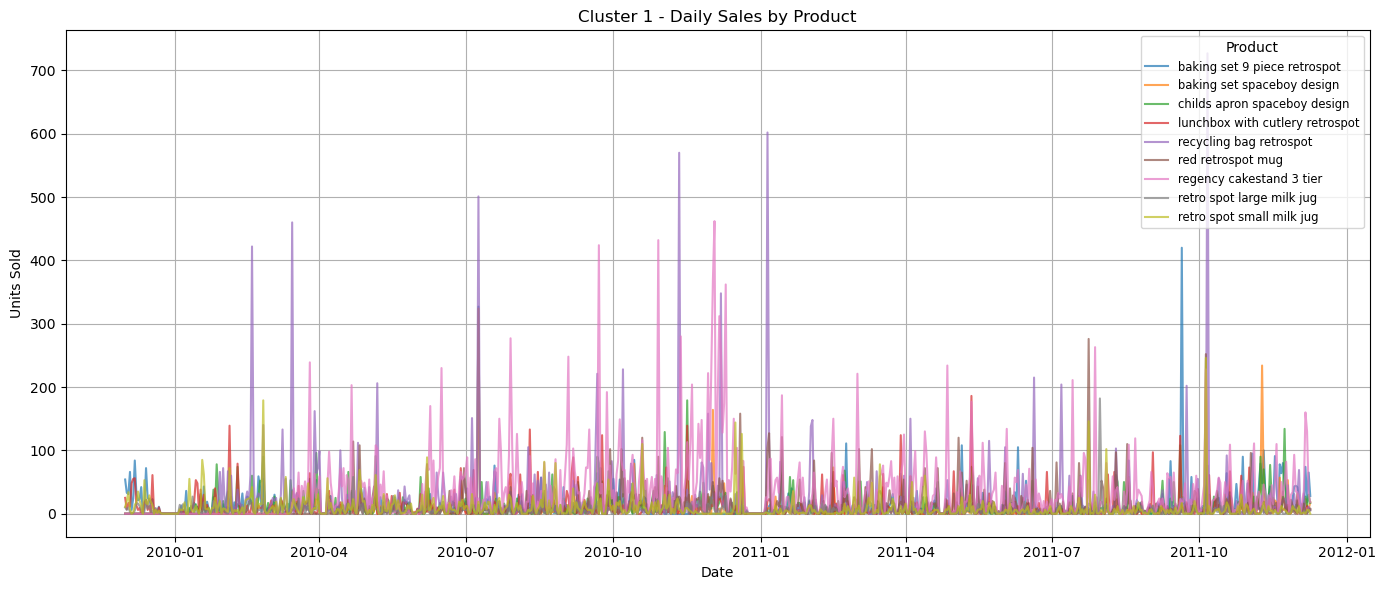

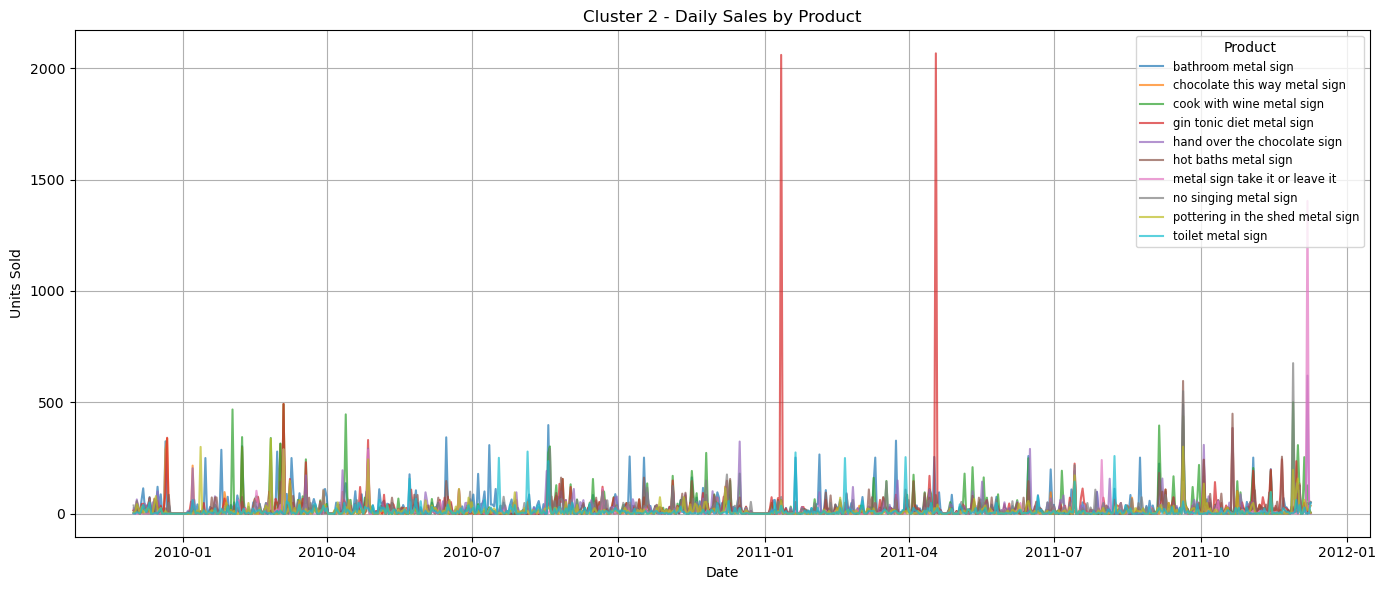

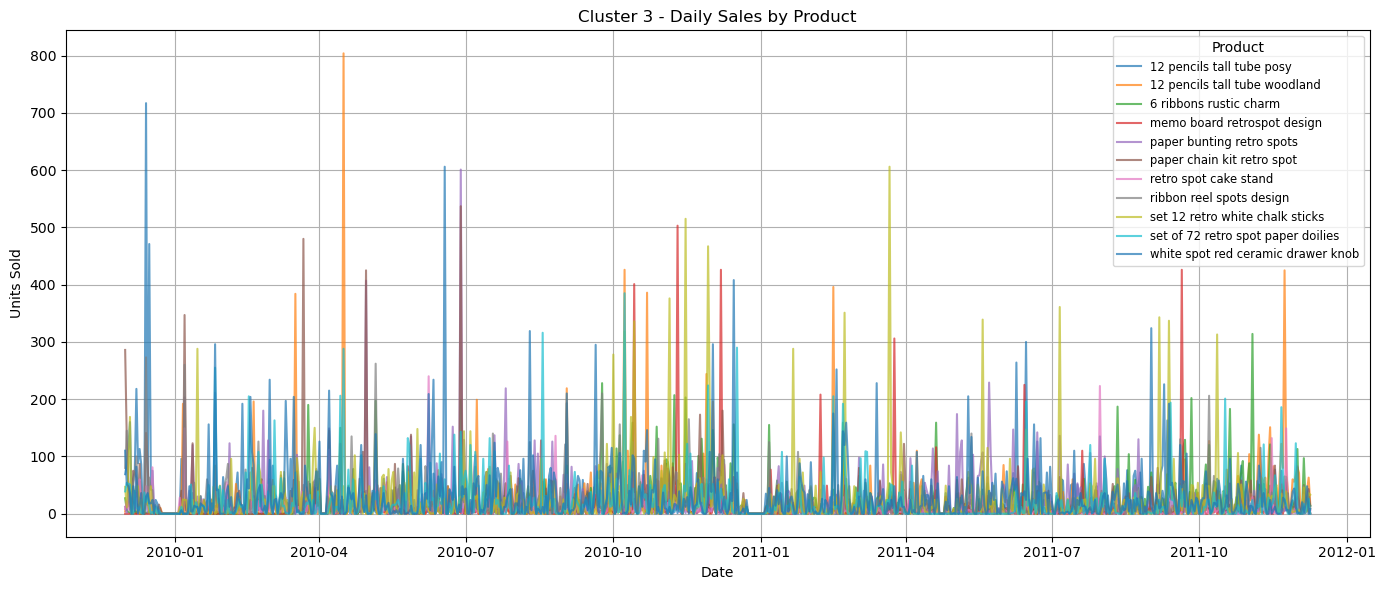

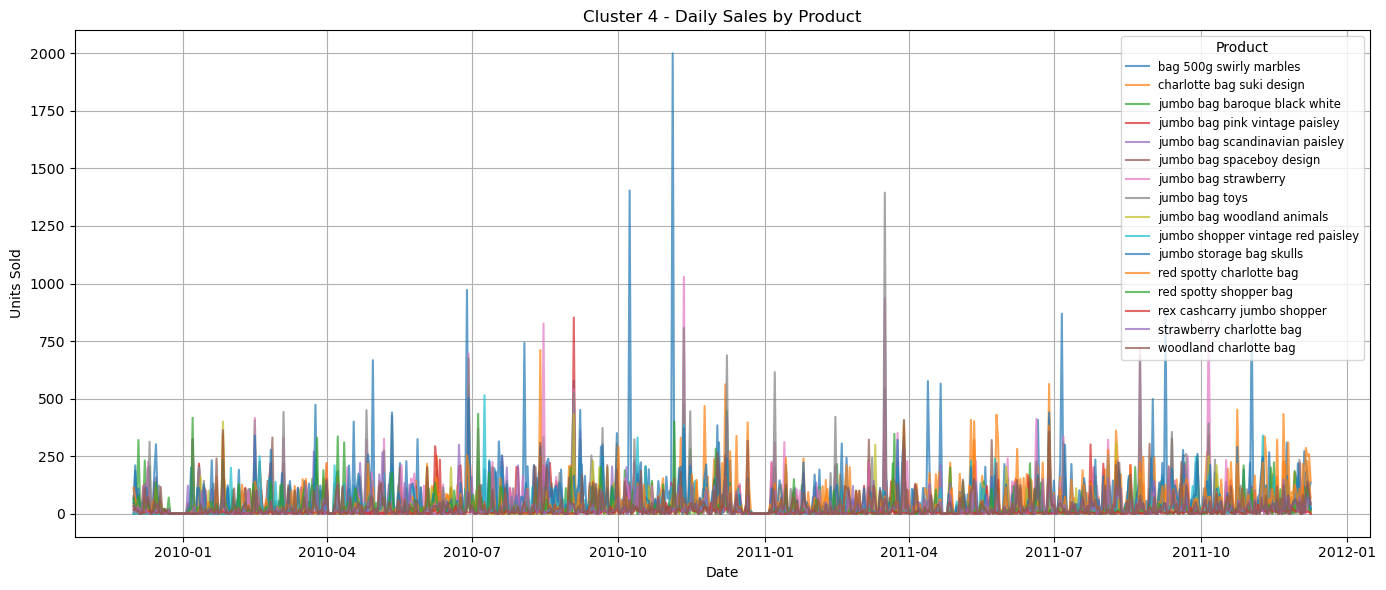

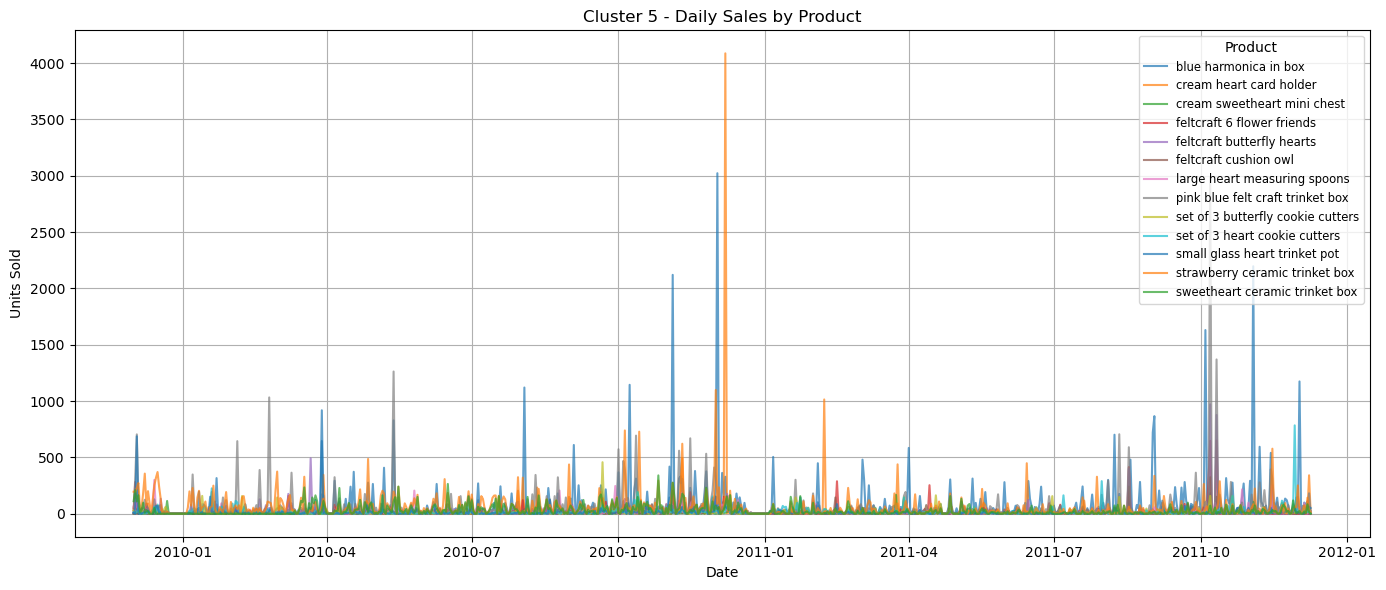

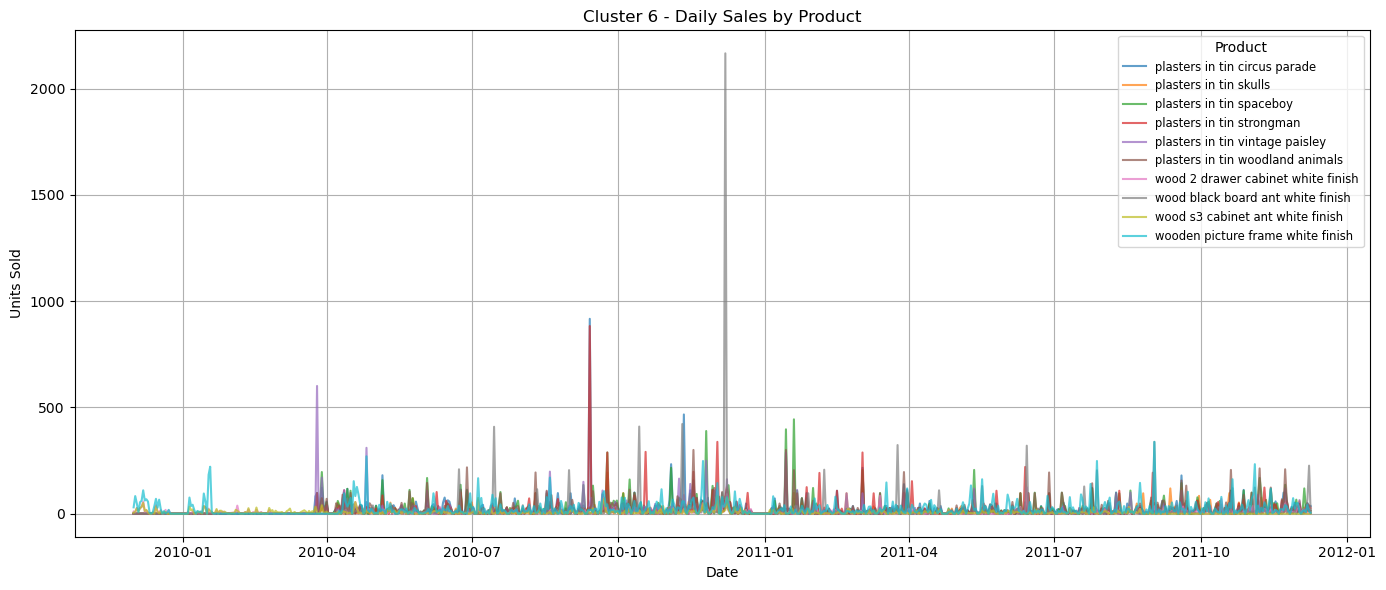

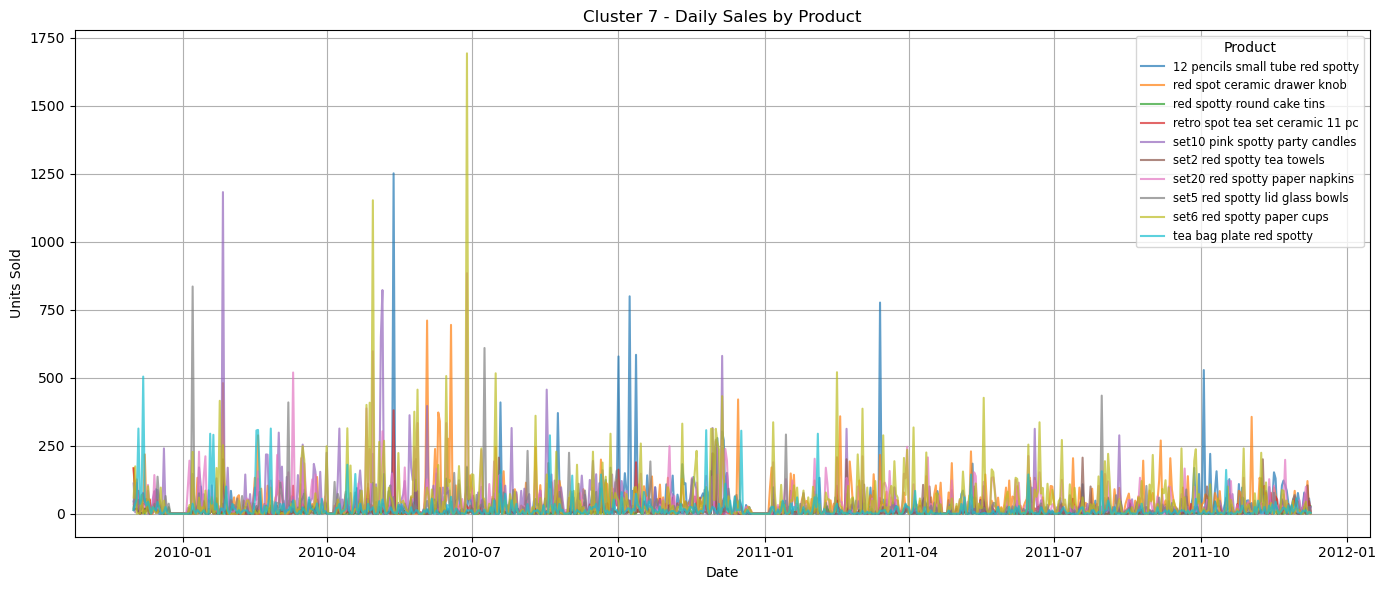

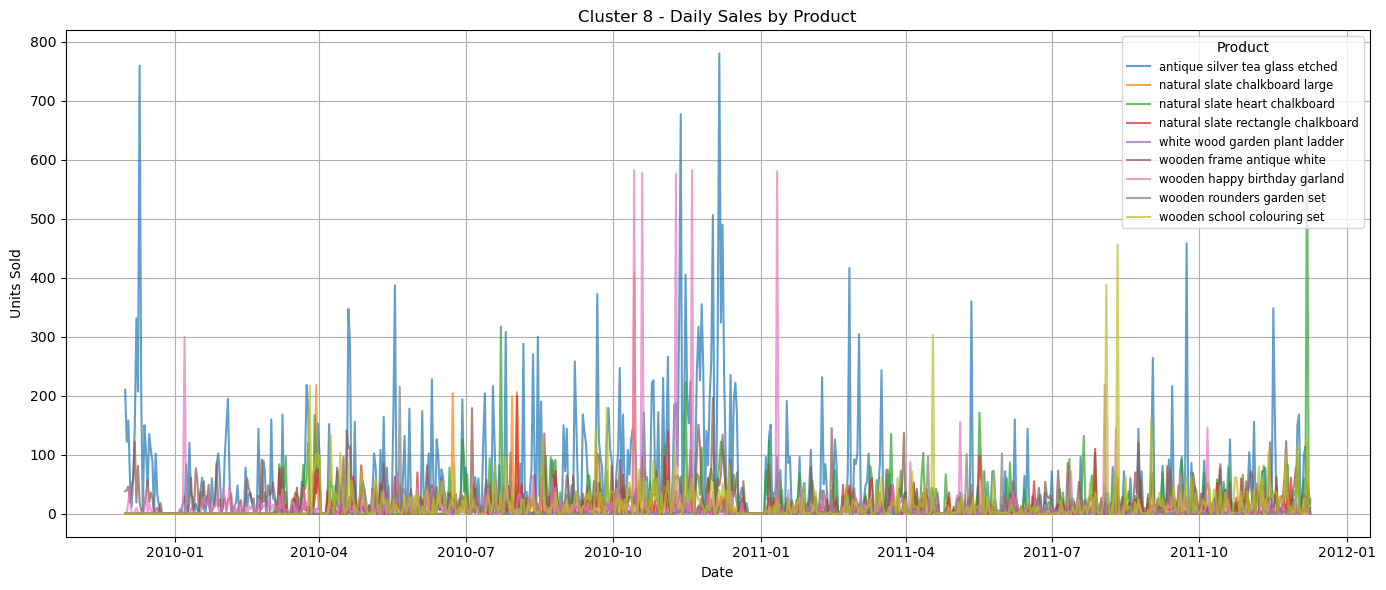

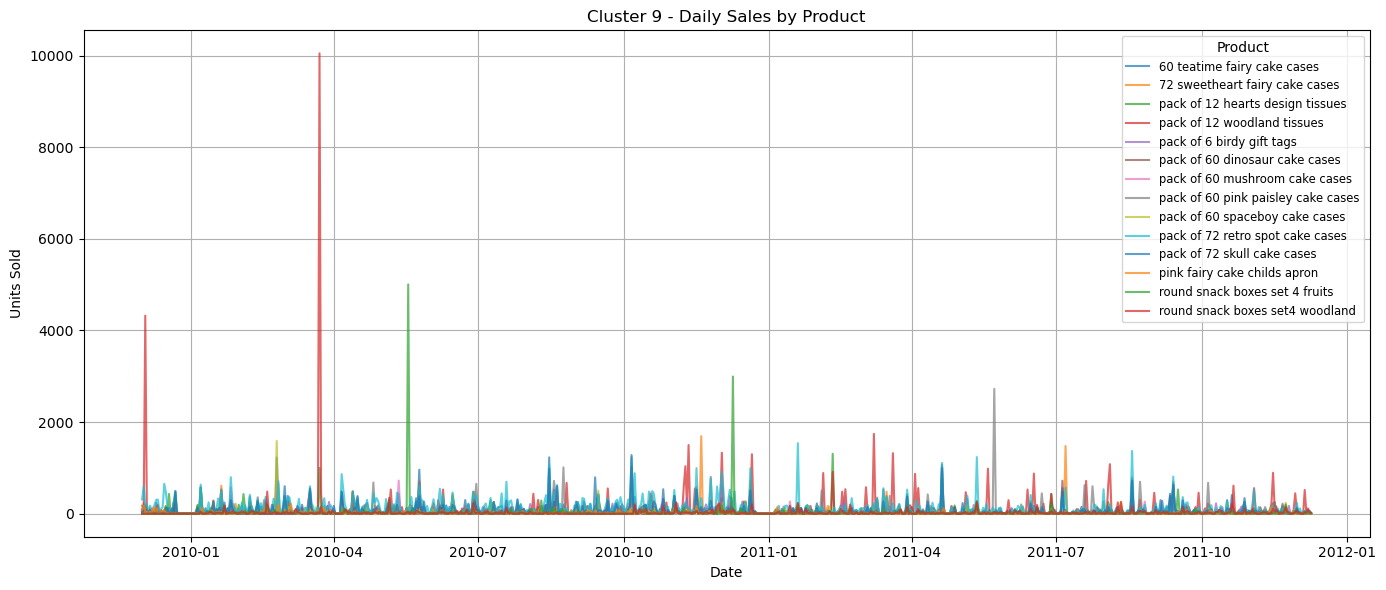

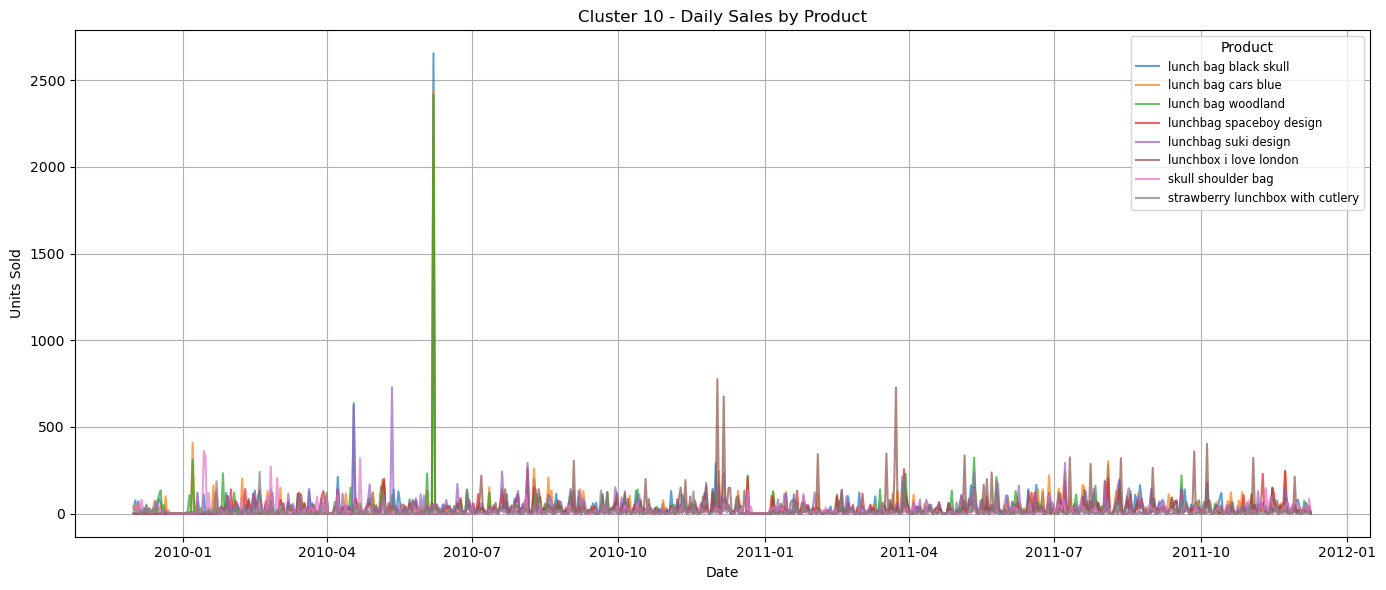

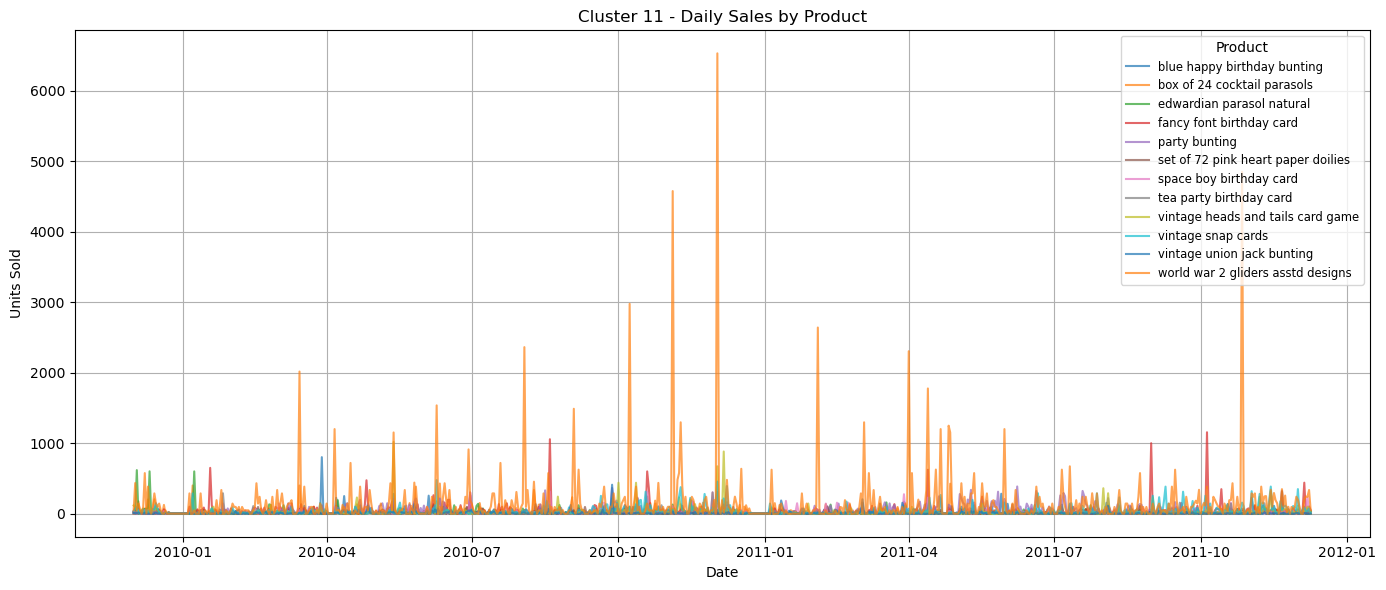

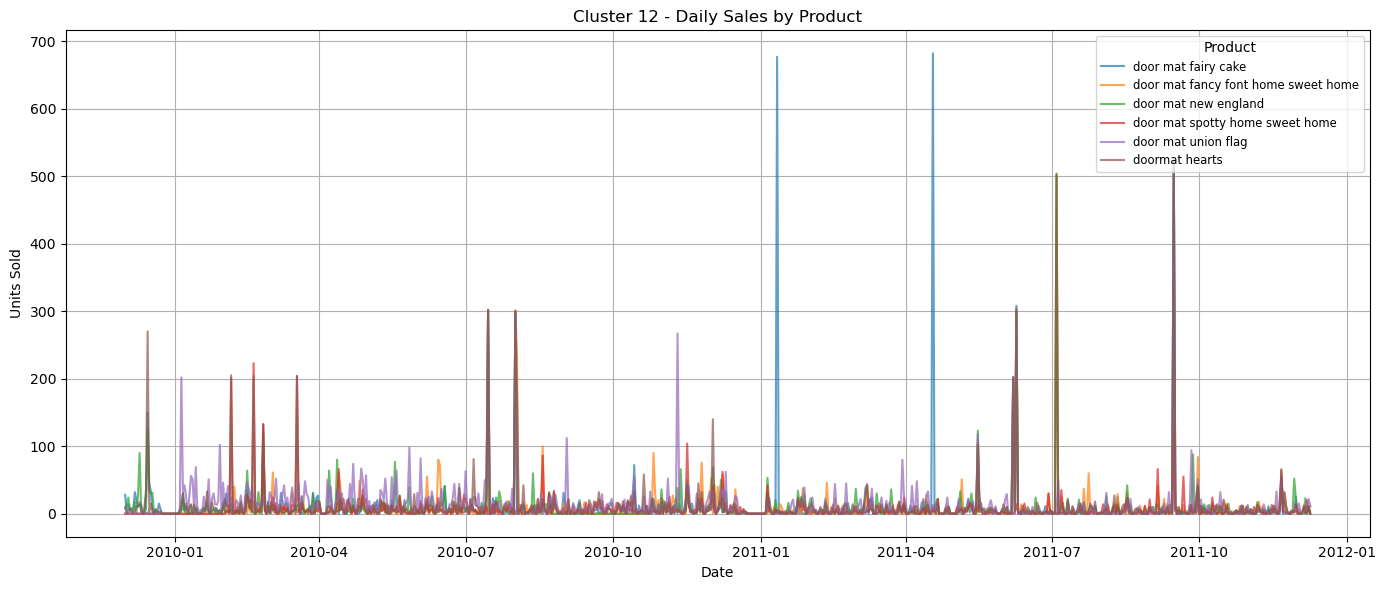

In [166]:
# Map products to clusters
product_cluster_map = pd.Series(description_df['K-Means_Cluster'])

for cluster_id in sorted(description_df['K-Means_Cluster'].unique()):
    # Filter data for current cluster
    cluster_df = df[df['K-Means_Cluster'] == cluster_id]

    # Group by Description and Date, summing UnitsSold
    grouped = cluster_df.groupby(['Description', 'Date'])['UnitsSold'].sum().unstack(fill_value=0)

    # Plot each product's time series
    plt.figure(figsize=(14, 6))
    for product in grouped.index:
        plt.plot(grouped.columns, grouped.loc[product], label=product, alpha=0.7)

    plt.title(f"Cluster {cluster_id} - Daily Sales by Product")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend(loc='upper right', fontsize='small', title='Product')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

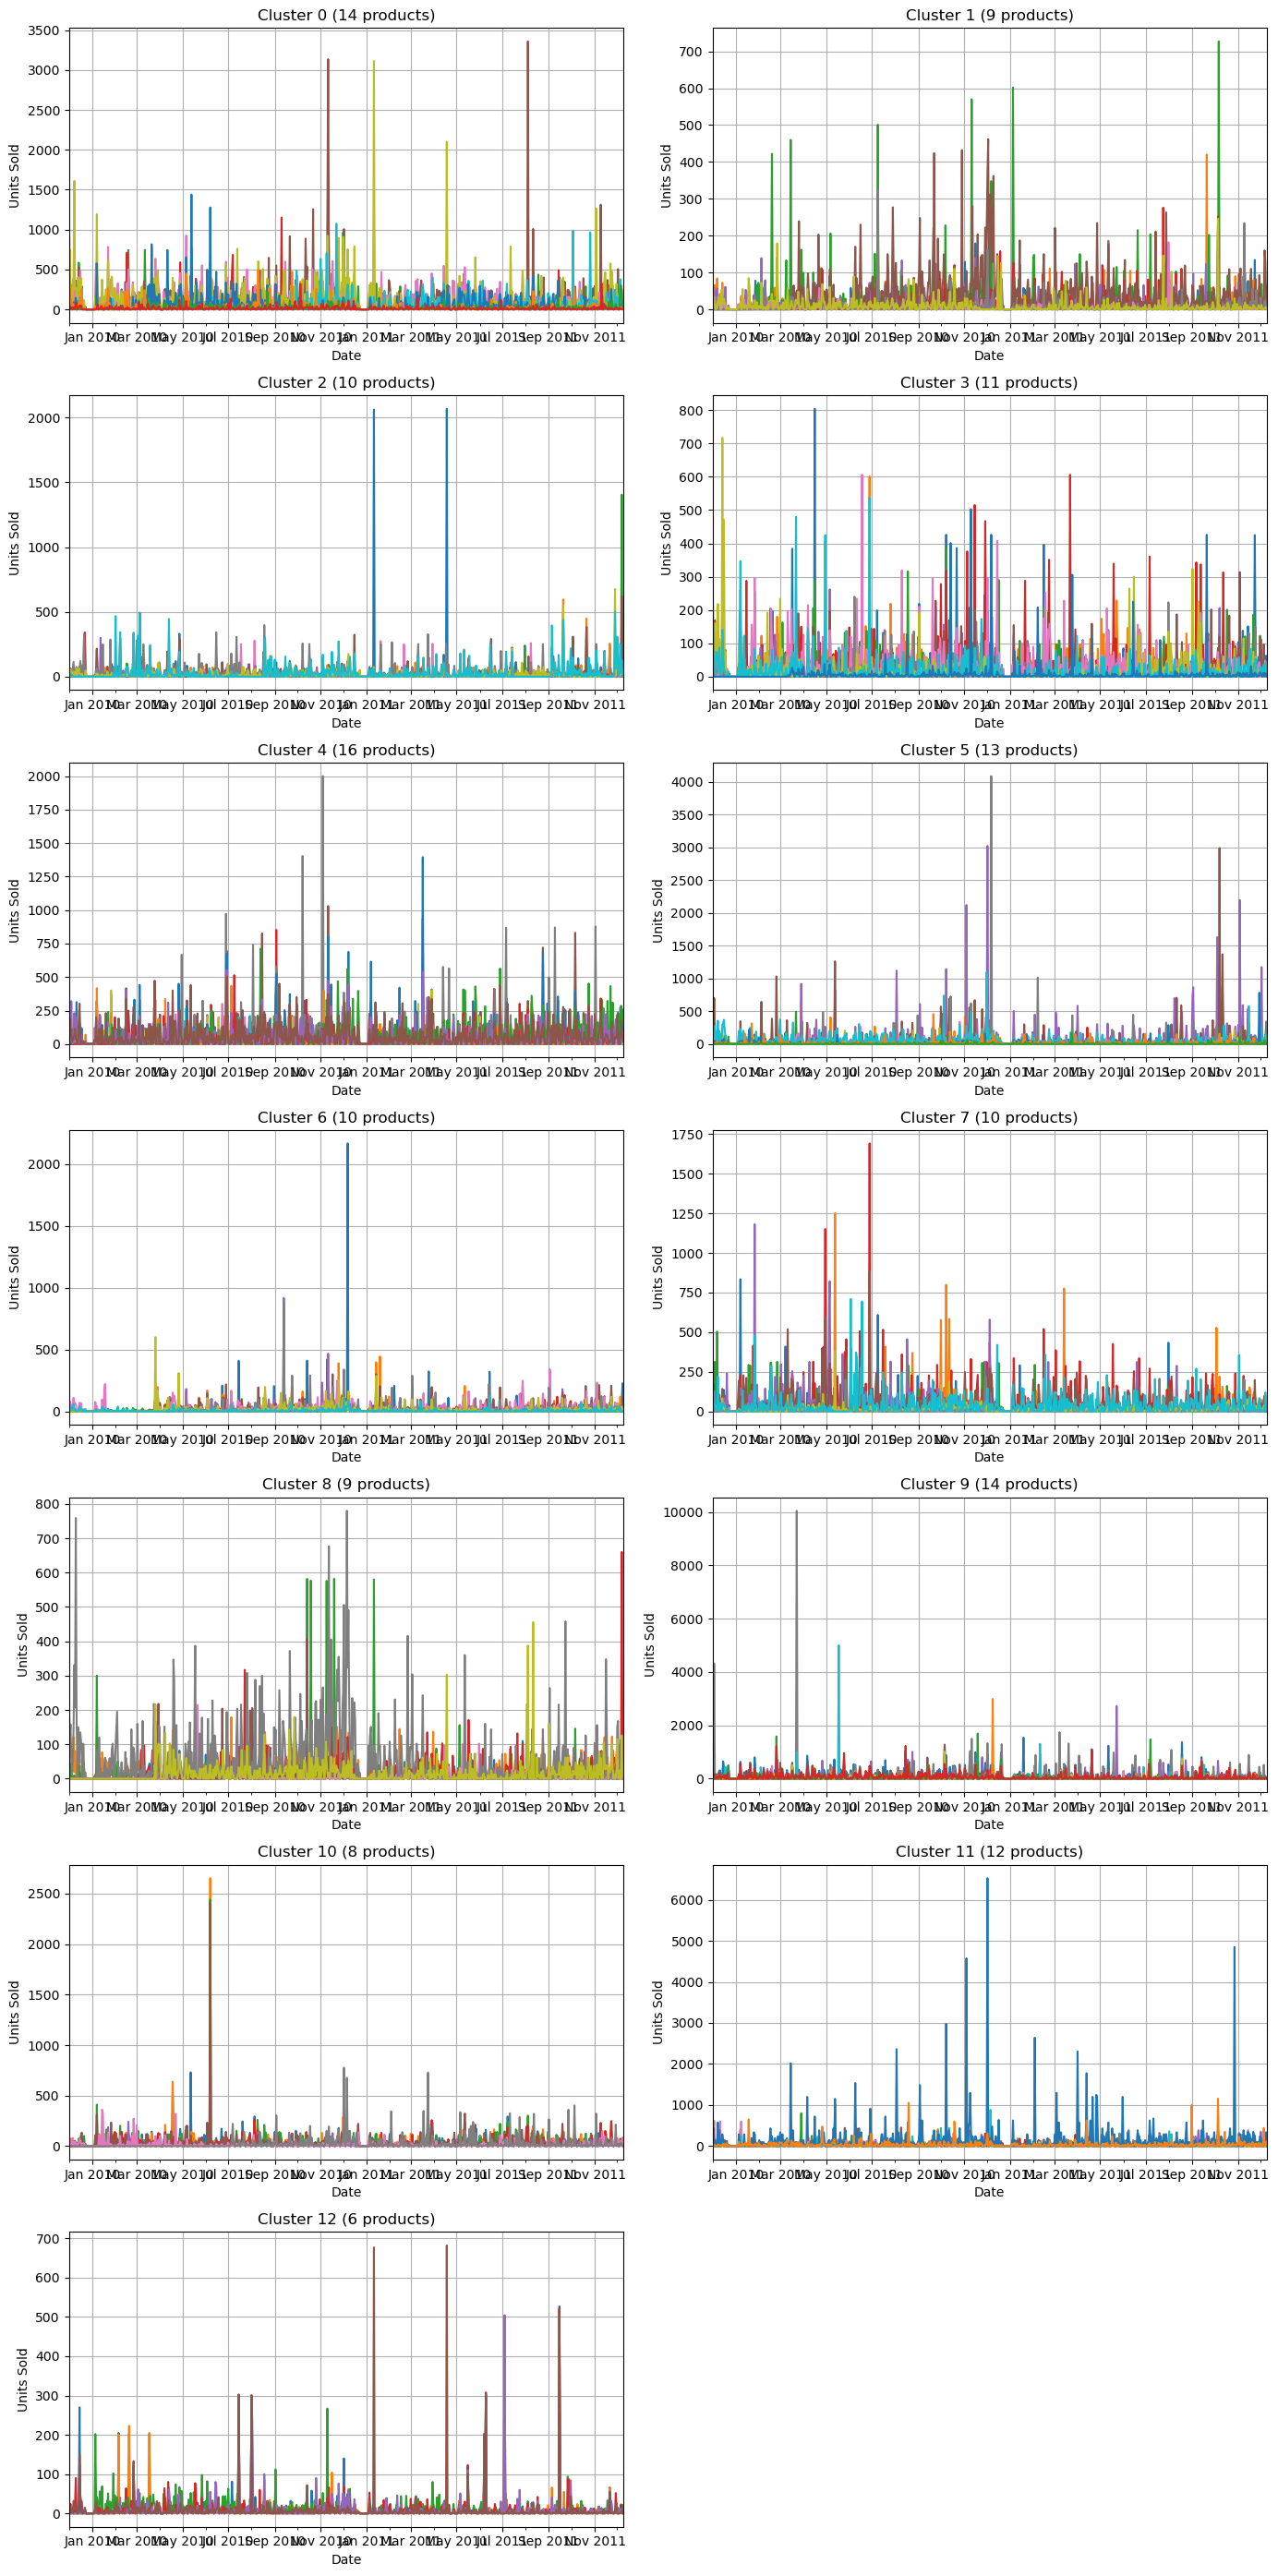

In [167]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['K-Means_Cluster'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['K-Means_Cluster'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [168]:
clusters = df.groupby('K-Means_Cluster')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- assorted colour bird ornament
- colour glass tlight holder hanging
- four hook white lovebirds
- hanging heart zinc tlight holder
- hanging jam jar tlight holder
- hanging metal star lantern
- ivory hanging decoration heart
- love building block word
- lovebird hanging decoration white
- mini cake stand hanging strawbery
- red toadstool led night light
- victorian glass hanging tlight
- white hanging heart tlight holder
- zinc metal heart decoration

Cluster 1:
- baking set 9 piece retrospot
- baking set spaceboy design
- childs apron spaceboy design
- lunchbox with cutlery retrospot
- recycling bag retrospot
- red retrospot mug
- regency cakestand 3 tier
- retro spot large milk jug
- retro spot small milk jug

Cluster 2:
- bathroom metal sign
- chocolate this way metal sign
- cook with wine metal sign
- gin tonic diet metal sign
- hand over the chocolate sign
- hot baths metal sign
- metal sign take it or leave it
- no singing metal sign
- pottering in the shed metal sign

# DBSCAN
(Density-Based Spatial Clustering of Applications with Noise)

In [169]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

In [170]:
def tune_dbscan(embeddings, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_labels = None
    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(embeddings)

            # Skip if all points are noise or only one cluster
            if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
                continue

            score = silhouette_score(embeddings, labels)
            print(f"eps={eps}, min_samples={min_samples}, silhouette_score={score:.4f}")

            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_labels = labels

    if best_params is None:
        print("\n❌ No valid clusters found.")
        return None, None, None

    print(f"\n✅ Best Params: eps={best_params[0]}, min_samples={best_params[1]}, silhouette_score={best_score:.4f}")
    return best_labels, best_params, pd.DataFrame(results)


In [171]:
eps_range = np.linspace(0.3, 10.0, 30)
min_samples_range = list(range(2, 15))

In [172]:
labels, best_params, results_df = tune_dbscan(embeddings, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=-0.0353
eps=0.6344827586206896, min_samples=2, silhouette_score=0.0790
eps=0.6344827586206896, min_samples=3, silhouette_score=0.0720
eps=0.6344827586206896, min_samples=4, silhouette_score=0.0388
eps=0.6344827586206896, min_samples=5, silhouette_score=0.0172
eps=0.6344827586206896, min_samples=6, silhouette_score=0.0155
eps=0.6344827586206896, min_samples=7, silhouette_score=0.0040
eps=0.6344827586206896, min_samples=8, silhouette_score=0.0070

✅ Best Params: eps=0.6344827586206896, min_samples=2, silhouette_score=0.0790


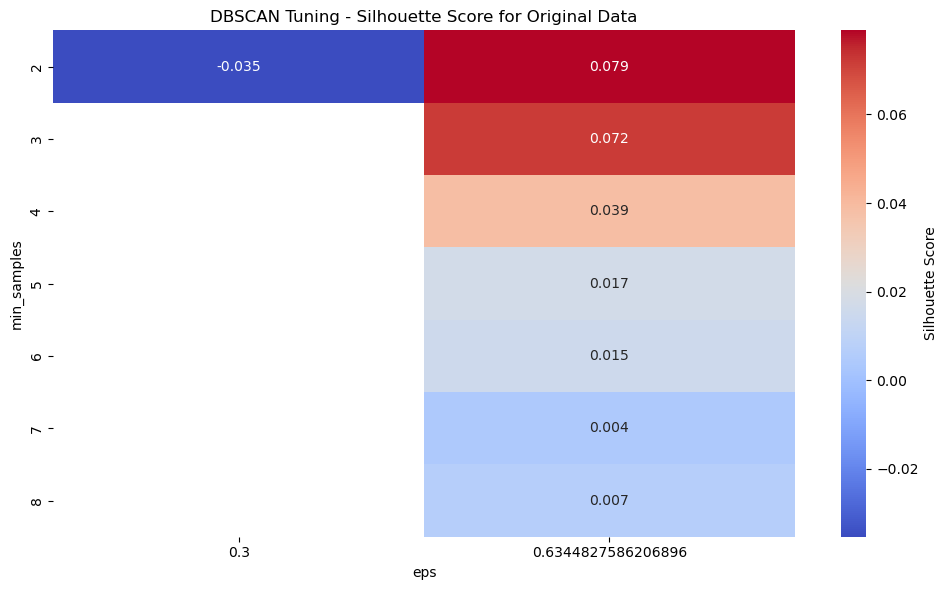

In [173]:
heatmap_data = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Tuning - Silhouette Score for Original Data')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout()
plt.show()

In [174]:
labels, best_params, results_df = tune_dbscan(reduced, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.1337
eps=0.3, min_samples=3, silhouette_score=0.1663
eps=0.3, min_samples=4, silhouette_score=0.1663
eps=0.3, min_samples=5, silhouette_score=0.2048
eps=0.3, min_samples=6, silhouette_score=0.1604
eps=0.3, min_samples=7, silhouette_score=0.1413
eps=0.3, min_samples=8, silhouette_score=0.1360
eps=0.3, min_samples=9, silhouette_score=0.1303
eps=0.3, min_samples=10, silhouette_score=0.1296
eps=0.3, min_samples=11, silhouette_score=0.0370
eps=0.3, min_samples=12, silhouette_score=0.0205
eps=0.3, min_samples=13, silhouette_score=0.0206

✅ Best Params: eps=0.3, min_samples=5, silhouette_score=0.2048


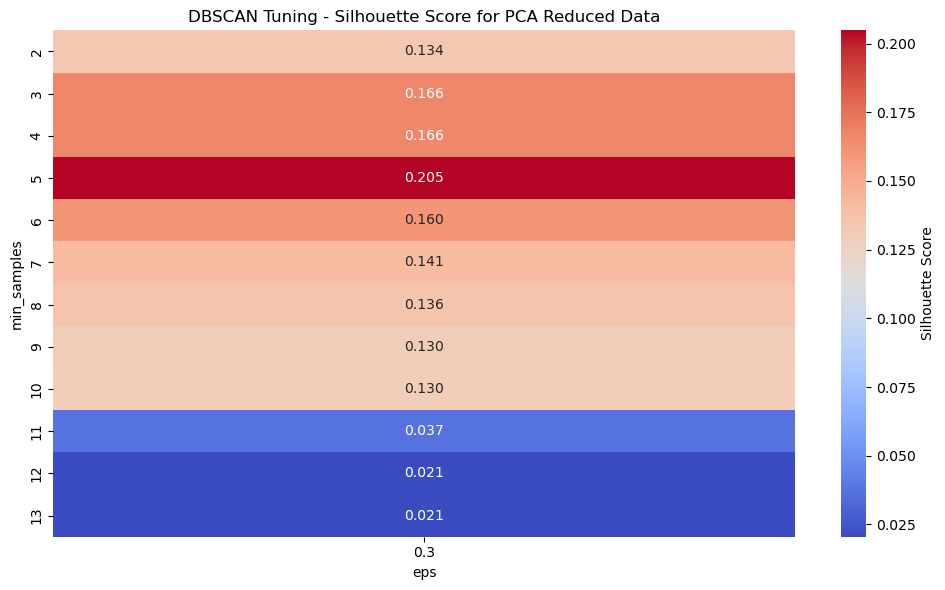

In [175]:
heatmap_data = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Tuning - Silhouette Score for PCA Reduced Data')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout()
plt.show()

In [176]:
labels, best_params, results_df = tune_dbscan(umap_reduced, eps_range, min_samples_range)

eps=0.3, min_samples=2, silhouette_score=0.4704
eps=0.3, min_samples=3, silhouette_score=0.3350
eps=0.3, min_samples=4, silhouette_score=0.1806
eps=0.3, min_samples=5, silhouette_score=0.0996
eps=0.3, min_samples=6, silhouette_score=-0.0223
eps=0.3, min_samples=7, silhouette_score=0.2056
eps=0.6344827586206896, min_samples=2, silhouette_score=0.4735
eps=0.6344827586206896, min_samples=3, silhouette_score=0.4735
eps=0.6344827586206896, min_samples=4, silhouette_score=0.4735
eps=0.6344827586206896, min_samples=5, silhouette_score=0.1977
eps=0.6344827586206896, min_samples=6, silhouette_score=0.1713
eps=0.6344827586206896, min_samples=7, silhouette_score=0.3099
eps=0.6344827586206896, min_samples=8, silhouette_score=0.3758
eps=0.6344827586206896, min_samples=9, silhouette_score=0.3434
eps=0.6344827586206896, min_samples=10, silhouette_score=0.2573
eps=0.6344827586206896, min_samples=11, silhouette_score=0.1156
eps=0.6344827586206896, min_samples=12, silhouette_score=0.0184
eps=0.634482758

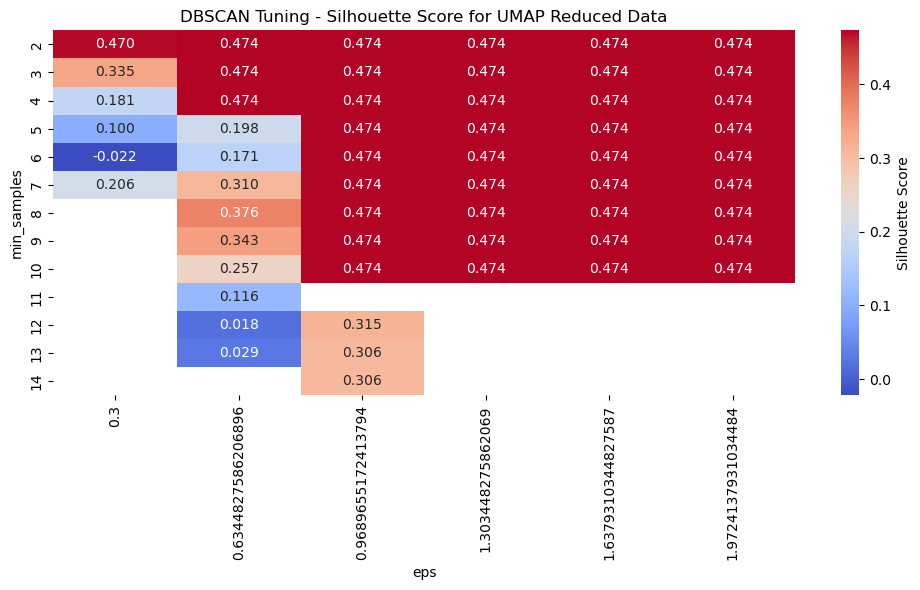

In [177]:
heatmap_data = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Tuning - Silhouette Score for UMAP Reduced Data')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.tight_layout()
plt.show()

In [178]:
description_df['DBScan'] = labels

In [179]:
df = df.merge(
    description_df[['Description', 'DBScan']],
    left_on='Description',
    right_on='Description',
    how='left'
)

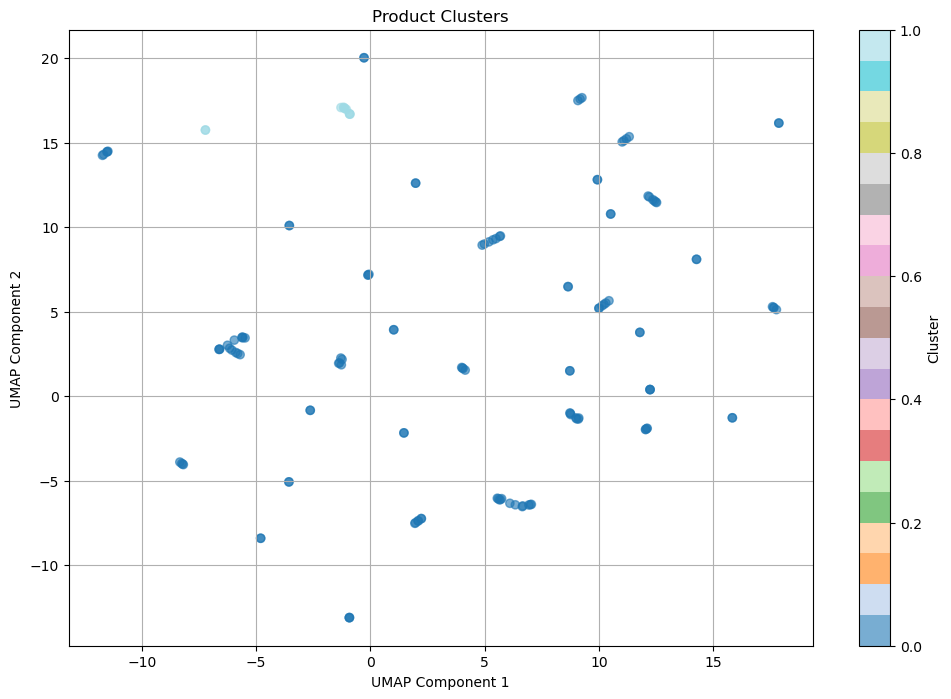

In [180]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['DBScan'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

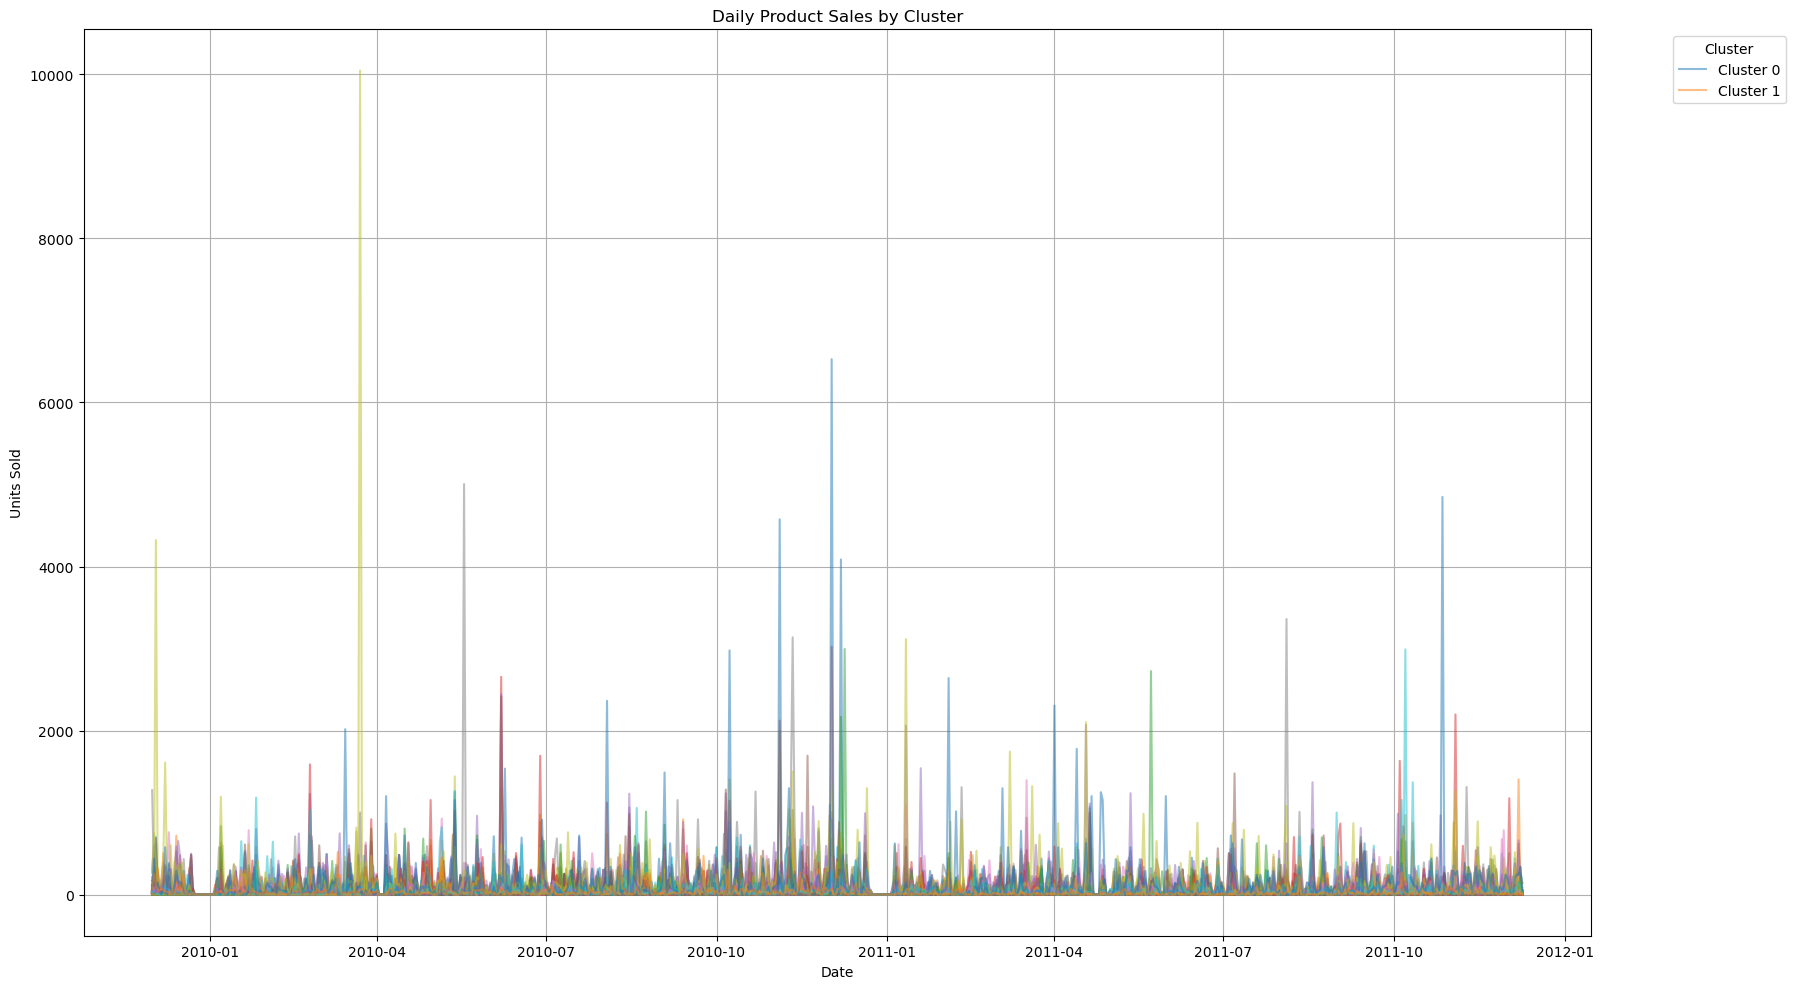

In [181]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'DBScan'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

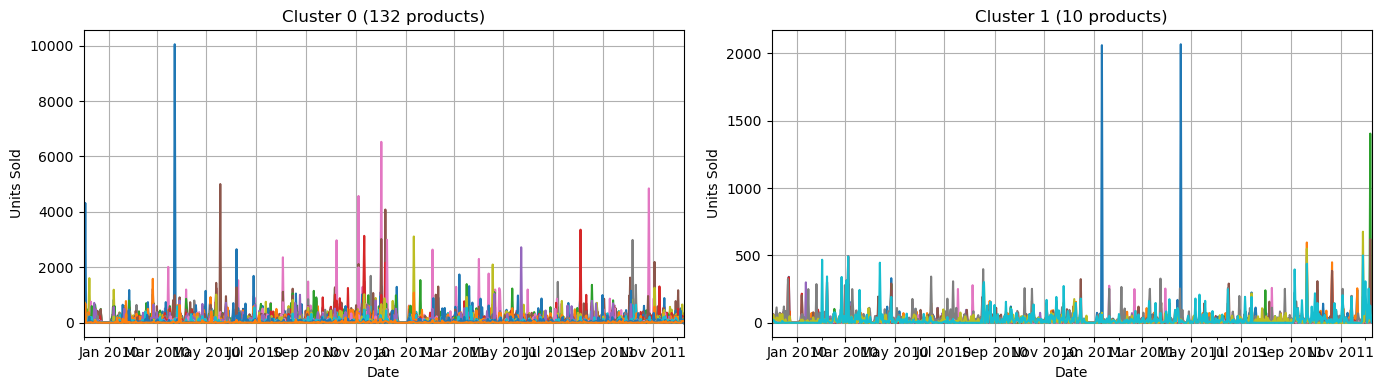

In [182]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['DBScan'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['DBScan'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [183]:
clusters = df.groupby('DBScan')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- 12 pencils small tube red spotty
- 12 pencils tall tube posy
- 12 pencils tall tube woodland
- 6 ribbons rustic charm
- 60 teatime fairy cake cases
- 72 sweetheart fairy cake cases
- antique silver tea glass etched
- assorted colour bird ornament
- bag 500g swirly marbles
- baking set 9 piece retrospot
- baking set spaceboy design
- blue happy birthday bunting
- blue harmonica in box
- box of 24 cocktail parasols
- charlotte bag suki design
- childs apron spaceboy design
- colour glass tlight holder hanging
- cream heart card holder
- cream sweetheart mini chest
- door mat fairy cake
- door mat fancy font home sweet home
- door mat new england
- door mat spotty home sweet home
- door mat union flag
- doormat hearts
- edwardian parasol natural
- fancy font birthday card
- feltcraft 6 flower friends
- feltcraft butterfly hearts
- feltcraft cushion owl
- four hook white lovebirds
- hanging heart zinc tlight holder
- hanging jam jar tlight holder
- hanging metal star lantern
-

# HDBSCAN (Hierarchical DBSCAN)

In [184]:
import hdbscan

In [185]:
def tune_hdbscan(embeddings, min_cluster_sizes):
    best_score = -1
    best_params = None
    best_labels = None
    scores = []
    min_clusters = []

    for size in min_cluster_sizes:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        labels = clusterer.fit_predict(embeddings)

        # Skip runs with only one cluster or all noise
        unique_labels = set(labels)
        if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
            continue

        score = silhouette_score(embeddings, labels)
        print(f"min_cluster_size={size}, silhouette_score={score:.4f}")

        scores.append(score)
        min_clusters.append(size)

        if score > best_score:
            best_score = score
            best_params = size
            best_labels = labels

    if best_params is None:
        print("\n❌ No valid clustering found.")
        return None, None

    print(f"\n✅ Best min_cluster_size: {best_params} with silhouette_score={best_score:.4f}")
    return best_labels, best_params, scores, min_clusters

In [186]:
min_cluster_sizes = range(2, 20)
labels, best_size, scores, min_clusters = tune_hdbscan(embeddings, min_cluster_sizes)

min_cluster_size=2, silhouette_score=0.0694
min_cluster_size=3, silhouette_score=0.0345
min_cluster_size=4, silhouette_score=0.0268
min_cluster_size=5, silhouette_score=0.0251
min_cluster_size=6, silhouette_score=0.0175
min_cluster_size=7, silhouette_score=0.0174
min_cluster_size=8, silhouette_score=0.0139

✅ Best min_cluster_size: 2 with silhouette_score=0.0694


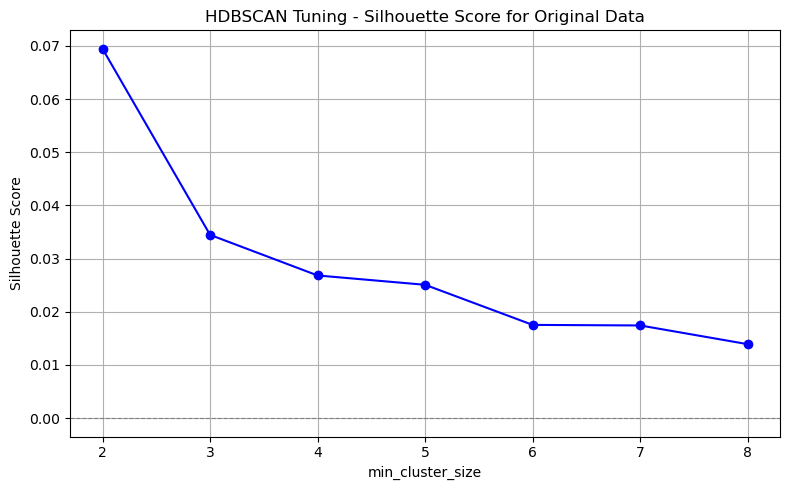

In [187]:
plt.figure(figsize=(8, 5))
plt.plot(min_clusters, scores, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('HDBSCAN Tuning - Silhouette Score for Original Data')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [188]:
min_cluster_sizes = range(2, 20)
labels, best_size, scores, min_clusters = tune_hdbscan(reduced, min_cluster_sizes)

min_cluster_size=2, silhouette_score=0.1929
min_cluster_size=3, silhouette_score=0.1760
min_cluster_size=4, silhouette_score=0.1280
min_cluster_size=5, silhouette_score=0.1088
min_cluster_size=6, silhouette_score=0.0921
min_cluster_size=7, silhouette_score=0.0227
min_cluster_size=8, silhouette_score=0.0717
min_cluster_size=9, silhouette_score=0.0466
min_cluster_size=10, silhouette_score=-0.0006

✅ Best min_cluster_size: 2 with silhouette_score=0.1929


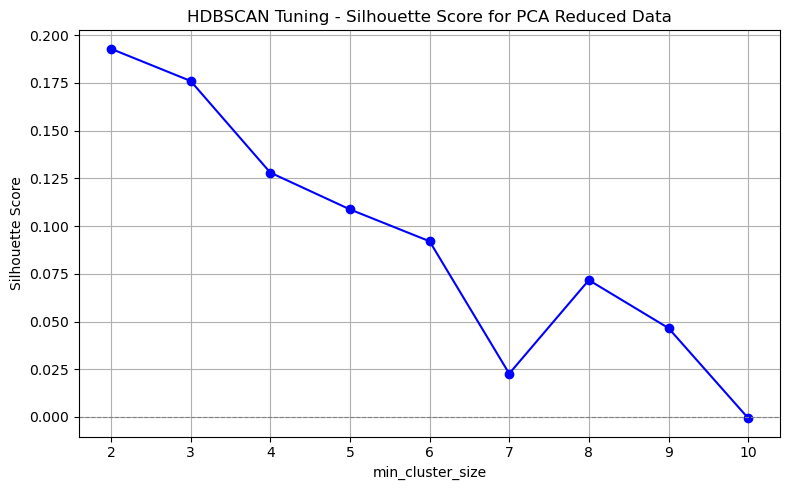

In [189]:
plt.figure(figsize=(8, 5))
plt.plot(min_clusters, scores, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('HDBSCAN Tuning - Silhouette Score for PCA Reduced Data')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [190]:
min_cluster_sizes = range(2, 20)
labels, best_size, scores, min_clusters = tune_hdbscan(umap_reduced, min_cluster_sizes)


min_cluster_size=2, silhouette_score=0.4057
min_cluster_size=3, silhouette_score=0.3375
min_cluster_size=4, silhouette_score=0.4735
min_cluster_size=5, silhouette_score=0.4735
min_cluster_size=6, silhouette_score=0.4735
min_cluster_size=7, silhouette_score=0.4735
min_cluster_size=8, silhouette_score=0.4735
min_cluster_size=9, silhouette_score=0.4735
min_cluster_size=10, silhouette_score=0.1834
min_cluster_size=11, silhouette_score=0.1782
min_cluster_size=12, silhouette_score=0.1764
min_cluster_size=13, silhouette_score=0.1481
min_cluster_size=14, silhouette_score=0.1677

✅ Best min_cluster_size: 4 with silhouette_score=0.4735


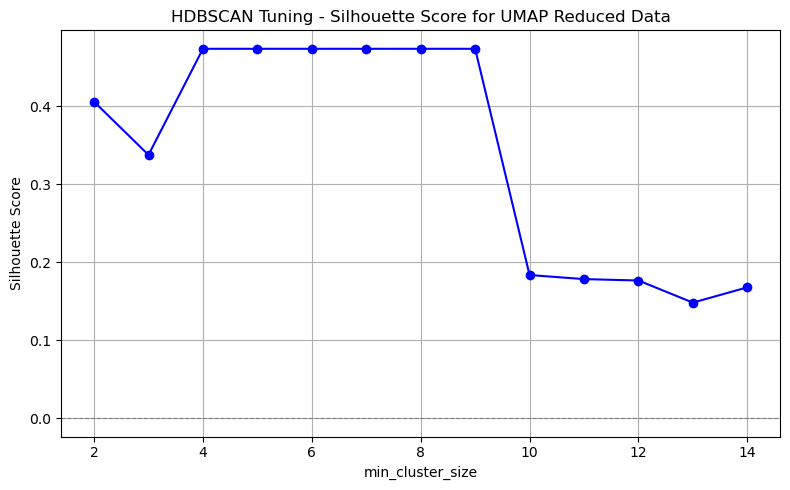

In [191]:
plt.figure(figsize=(8, 5))
plt.plot(min_clusters, scores, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('HDBSCAN Tuning - Silhouette Score for UMAP Reduced Data')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [192]:
description_df['HDBScan'] = labels

In [193]:
df = df.merge(
    description_df[['Description', 'HDBScan']],
    left_on='Description',
    right_on='Description',
    how='left'
)

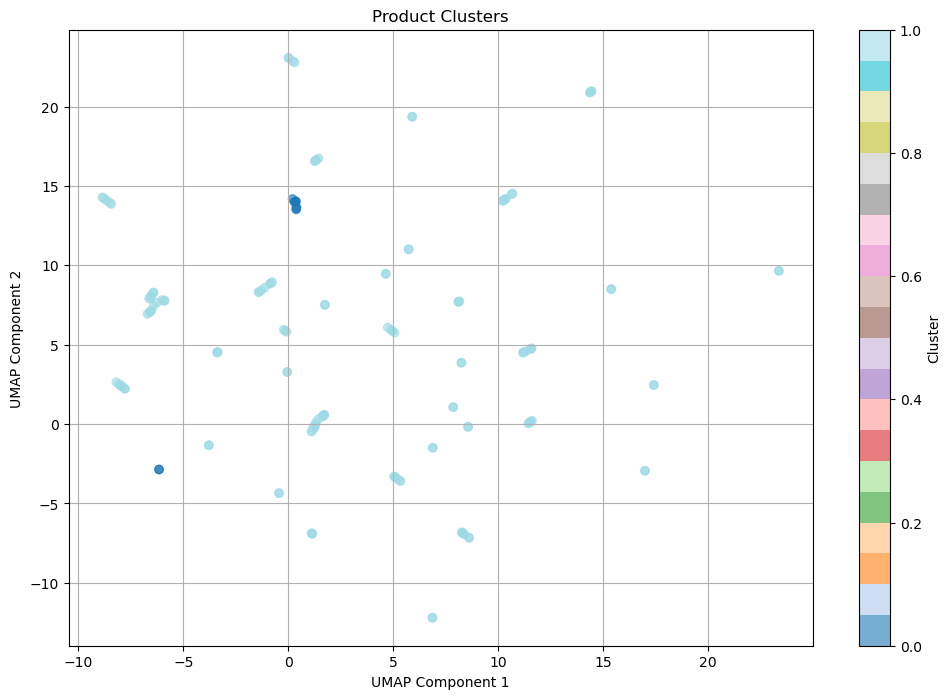

In [194]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['HDBScan'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

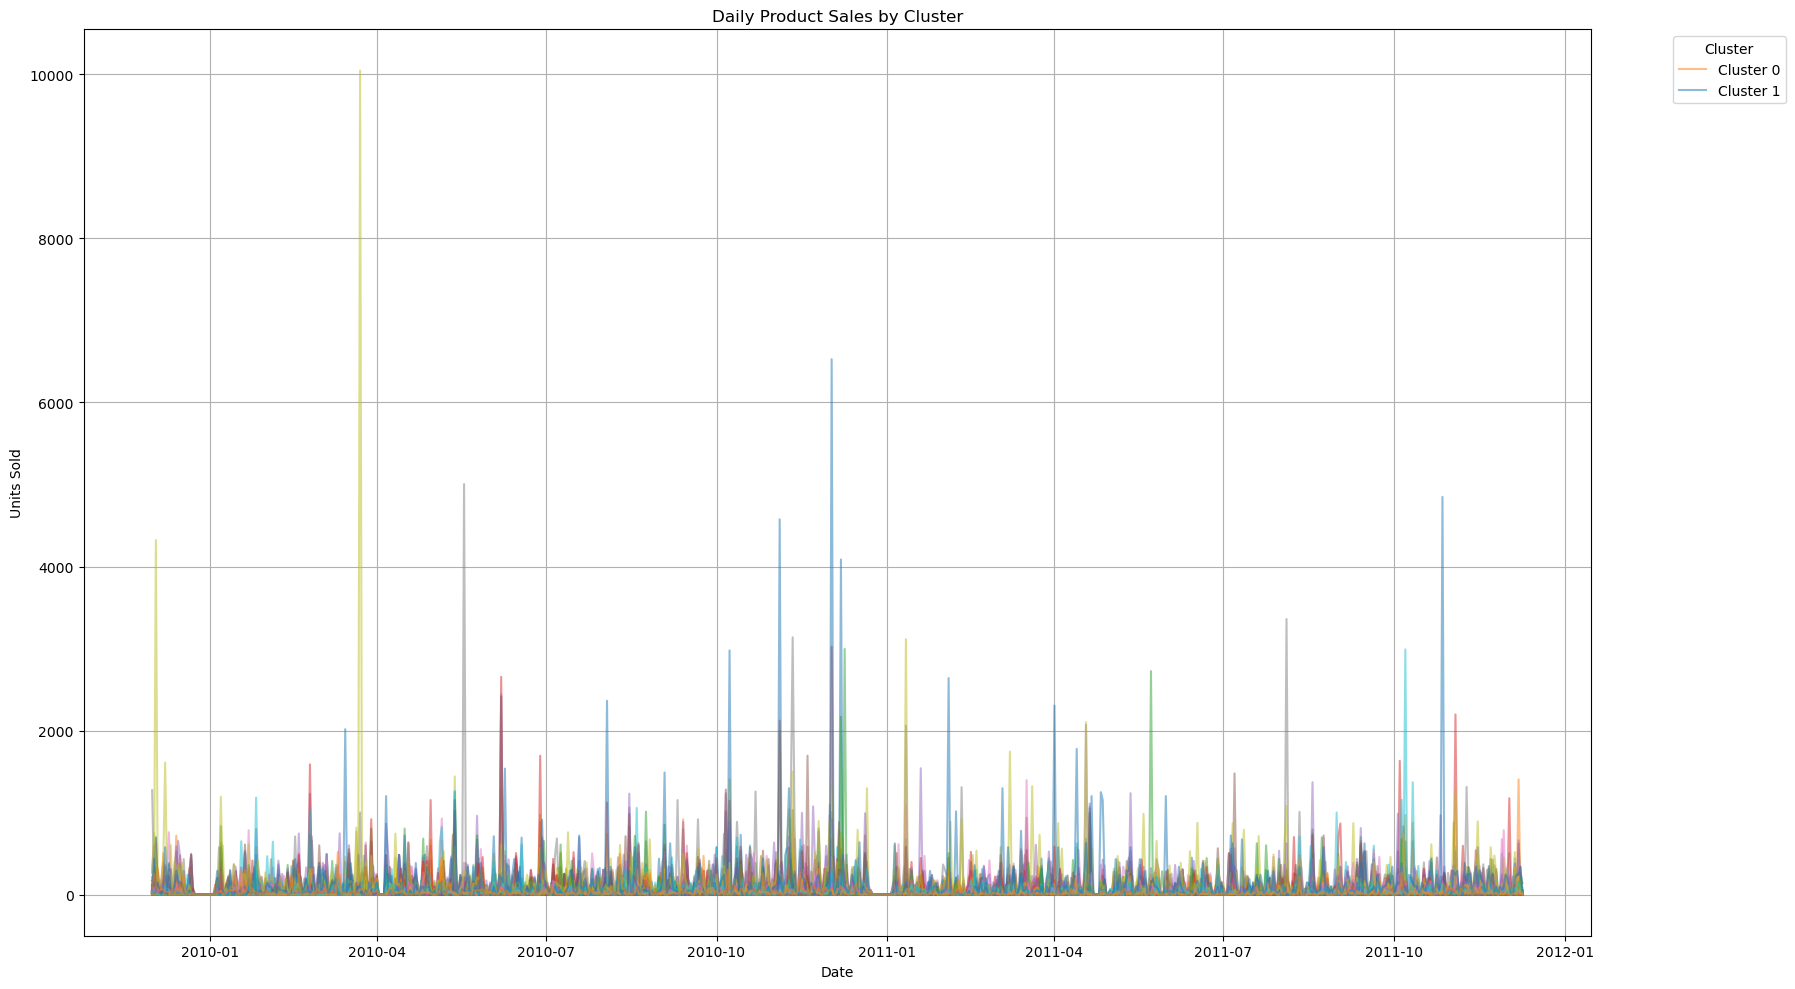

In [195]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'HDBScan'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

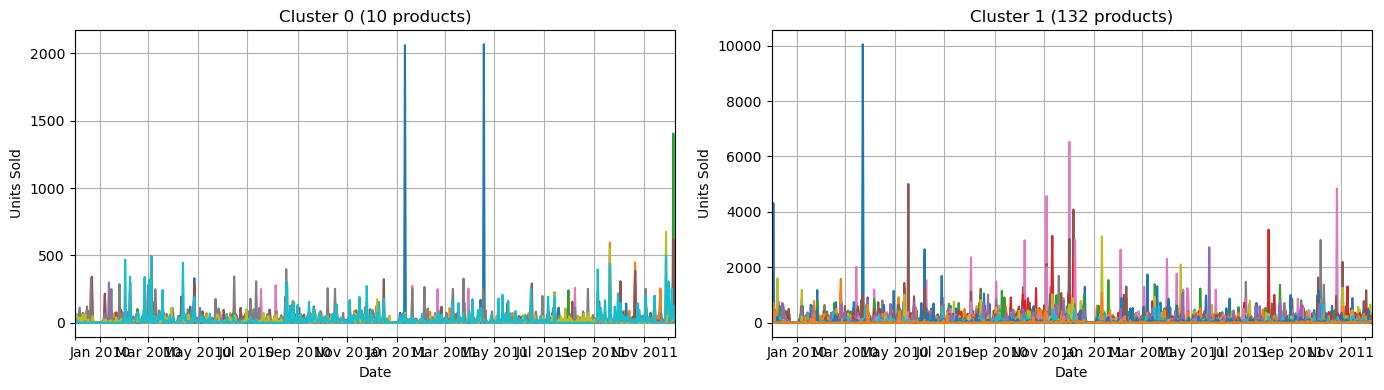

In [196]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['HDBScan'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['HDBScan'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [197]:
clusters = df.groupby('HDBScan')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- bathroom metal sign
- chocolate this way metal sign
- cook with wine metal sign
- gin tonic diet metal sign
- hand over the chocolate sign
- hot baths metal sign
- metal sign take it or leave it
- no singing metal sign
- pottering in the shed metal sign
- toilet metal sign

Cluster 1:
- 12 pencils small tube red spotty
- 12 pencils tall tube posy
- 12 pencils tall tube woodland
- 6 ribbons rustic charm
- 60 teatime fairy cake cases
- 72 sweetheart fairy cake cases
- antique silver tea glass etched
- assorted colour bird ornament
- bag 500g swirly marbles
- baking set 9 piece retrospot
- baking set spaceboy design
- blue happy birthday bunting
- blue harmonica in box
- box of 24 cocktail parasols
- charlotte bag suki design
- childs apron spaceboy design
- colour glass tlight holder hanging
- cream heart card holder
- cream sweetheart mini chest
- door mat fairy cake
- door mat fancy font home sweet home
- door mat new england
- door mat spotty home sweet home
- door mat un

# Agglomerative (Hierarchical) Clustering

In [198]:
from sklearn.cluster import AgglomerativeClustering

In [199]:
def tune_agglomerative(embeddings, cluster_range, linkages, affinities):
    best_score = -1
    best_params = None
    best_labels = None

    for linkage in linkages:
        valid_affinities = ['euclidean'] if linkage == 'ward' else affinities

        for affinity in valid_affinities:
            for n_clusters in cluster_range:
                try:
                    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                    labels = model.fit_predict(embeddings)

                    print(f"Labels found: {set(labels)}, Count: {len(set(labels))}")

                    if len(set(labels)) <= 1:
                        continue

                    score = silhouette_score(embeddings, labels)
                    print(f"n_clusters={n_clusters}, linkage={linkage}, affinity={affinity}, silhouette_score={score:.4f}")

                    if score > best_score:
                        best_score = score
                        best_params = (n_clusters, linkage, affinity)
                        best_labels = labels
                except Exception as e:
                    print(f"⚠️ Skipping n_clusters={n_clusters}, linkage={linkage}, affinity={affinity} due to error: {e}")

    if best_params:
        print(f"\n✅ Best Params: n_clusters={best_params[0]}, linkage={best_params[1]}, affinity={best_params[2]}, silhouette_score={best_score:.4f}")
    else:
        print("\n❌ No valid clustering found.")
    
    return best_labels, best_params

In [200]:
cluster_range = range(2, 30)
linkages = ['ward', 'complete', 'average']
affinities = ['euclidean', 'manhattan', 'cosine']

#labels, best_params = tune_agglomerative(embeddings=embeddings, cluster_range=cluster_range, linkages=linkages, affinities=affinities)


In [201]:
#labels, best_params = tune_agglomerative(embeddings=reduced, cluster_range=cluster_range, linkages=linkages, affinities=affinities)

In [202]:
#labels, best_params = tune_agglomerative(embeddings=umap_reduced, cluster_range=cluster_range, linkages=linkages, affinities=affinities)


# Spectral Clustering

In [203]:
from sklearn.cluster import SpectralClustering

In [204]:
def tune_spectral_clustering(embeddings, cluster_range, affinities):
    best_score = -1
    best_params = None
    best_labels = None
    results = []

    for affinity in affinities:
        for n_clusters in cluster_range:
            try:
                if affinity == 'nearest_neighbors':
                    model = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        n_neighbors=10,
                        assign_labels='kmeans',
                        random_state=42
                    )
                else:  # 'rbf'
                    model = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        assign_labels='kmeans',
                        random_state=42
                    )

                labels = model.fit_predict(embeddings)

                if len(set(labels)) <= 1:
                    continue  # Skip single-cluster results

                score = silhouette_score(embeddings, labels)
                print(f"n_clusters={n_clusters}, affinity={affinity}, silhouette_score={score:.4f}")

                results.append({
                    'n_clusters': n_clusters,
                    'affinity': affinity,
                    'silhouette_score': score
                })

                if score > best_score:
                    best_score = score
                    best_params = (n_clusters, affinity)
                    best_labels = labels

            except Exception as e:
                print(f"⚠️ Skipping n_clusters={n_clusters}, affinity={affinity}: {e}")

    if best_params:
        print(f"\n✅ Best Params: n_clusters={best_params[0]}, affinity={best_params[1]}, silhouette_score={best_score:.4f}")
    else:
        print("\n❌ No valid clustering found.")

    return best_labels, best_params, pd.DataFrame(results)

In [205]:
cluster_range = range(2, 21)
affinities = ['rbf', 'nearest_neighbors']

best_labels, best_params, result_df = tune_spectral_clustering(embeddings, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.0530
n_clusters=3, affinity=rbf, silhouette_score=0.0568
n_clusters=4, affinity=rbf, silhouette_score=0.0617
n_clusters=5, affinity=rbf, silhouette_score=0.0647
n_clusters=6, affinity=rbf, silhouette_score=0.0703


n_clusters=7, affinity=rbf, silhouette_score=0.0710
n_clusters=8, affinity=rbf, silhouette_score=0.0813
n_clusters=9, affinity=rbf, silhouette_score=0.0807
n_clusters=10, affinity=rbf, silhouette_score=0.0921
n_clusters=11, affinity=rbf, silhouette_score=0.0947
n_clusters=12, affinity=rbf, silhouette_score=0.0994
n_clusters=13, affinity=rbf, silhouette_score=0.1004
n_clusters=14, affinity=rbf, silhouette_score=0.1126
n_clusters=15, affinity=rbf, silhouette_score=0.1189
n_clusters=16, affinity=rbf, silhouette_score=0.1203
n_clusters=17, affinity=rbf, silhouette_score=0.1228
n_clusters=18, affinity=rbf, silhouette_score=0.1215
n_clusters=19, affinity=rbf, silhouette_score=0.1334
n_clusters=20, affinity=rbf, silhouette_score=0.1272
n_clusters=2, affinity=nearest_neighbors, silhouette_score=0.0389
n_clusters=3, affinity=nearest_neighbors, silhouette_score=0.0411
n_clusters=4, affinity=nearest_neighbors, silhouette_score=0.0507
n_clusters=5, affinity=nearest_neighbors, silhouette_score=0.05

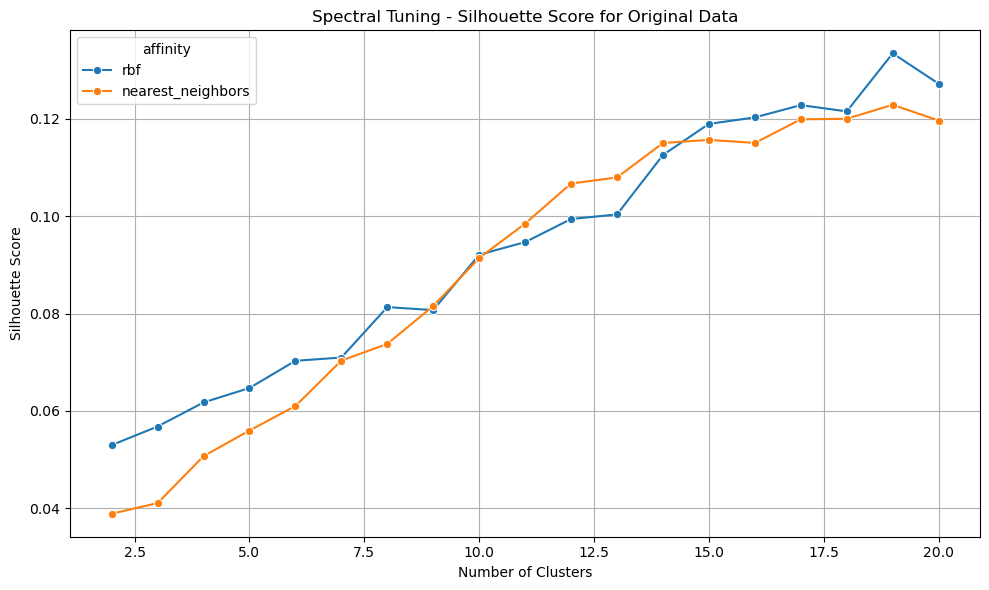

In [208]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df, x='n_clusters', y='silhouette_score', hue='affinity', marker='o')

plt.title('Spectral Tuning - Silhouette Score for Original Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [209]:
best_labels, best_params, result_df = tune_spectral_clustering(reduced, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.1404
n_clusters=3, affinity=rbf, silhouette_score=0.1620
n_clusters=4, affinity=rbf, silhouette_score=0.1708
n_clusters=5, affinity=rbf, silhouette_score=0.1869
n_clusters=6, affinity=rbf, silhouette_score=0.1964
n_clusters=7, affinity=rbf, silhouette_score=0.2183
n_clusters=8, affinity=rbf, silhouette_score=0.2273
n_clusters=9, affinity=rbf, silhouette_score=0.2343
n_clusters=10, affinity=rbf, silhouette_score=0.2608
n_clusters=11, affinity=rbf, silhouette_score=0.2802
n_clusters=12, affinity=rbf, silhouette_score=0.2682
n_clusters=13, affinity=rbf, silhouette_score=0.2728
n_clusters=14, affinity=rbf, silhouette_score=0.2594
n_clusters=15, affinity=rbf, silhouette_score=0.2488
n_clusters=16, affinity=rbf, silhouette_score=0.2718
n_clusters=17, affinity=rbf, silhouette_score=0.2540
n_clusters=18, affinity=rbf, silhouette_score=0.2403
n_clusters=19, affinity=rbf, silhouette_score=0.2440
n_clusters=20, affinity=rbf, silhouette_score=0.2431
n

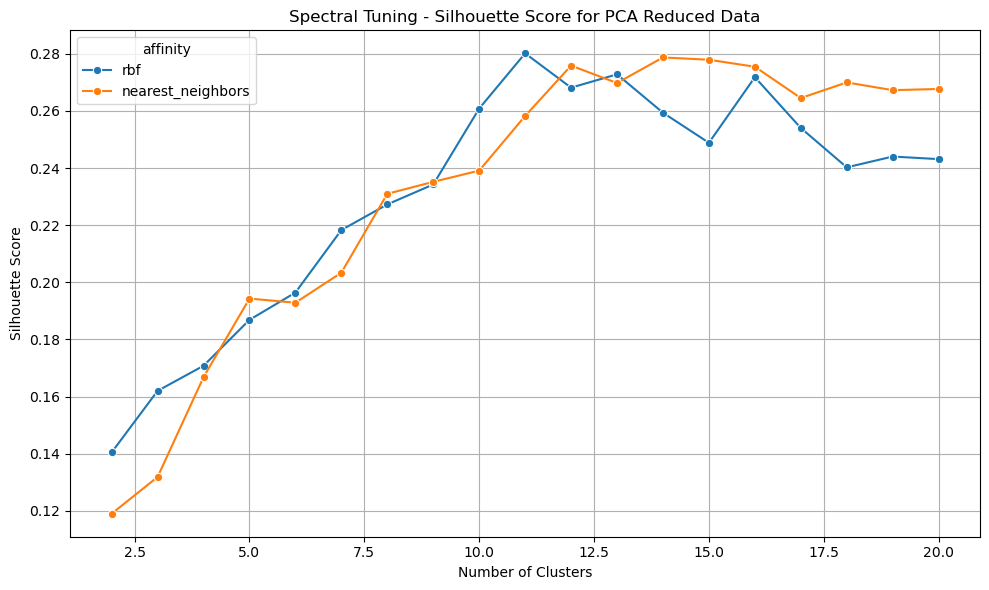

In [210]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df, x='n_clusters', y='silhouette_score', hue='affinity', marker='o')

plt.title('Spectral Tuning - Silhouette Score for PCA Reduced Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [211]:
labels, best_params, result_df = tune_spectral_clustering(umap_reduced, cluster_range, affinities)

n_clusters=2, affinity=rbf, silhouette_score=0.4735
n_clusters=3, affinity=rbf, silhouette_score=0.3850
n_clusters=4, affinity=rbf, silhouette_score=0.4279
n_clusters=5, affinity=rbf, silhouette_score=0.4768
n_clusters=6, affinity=rbf, silhouette_score=0.4891
n_clusters=7, affinity=rbf, silhouette_score=0.4900
n_clusters=8, affinity=rbf, silhouette_score=0.4818
n_clusters=9, affinity=rbf, silhouette_score=0.5004
n_clusters=10, affinity=rbf, silhouette_score=0.4915
n_clusters=11, affinity=rbf, silhouette_score=0.4988
n_clusters=12, affinity=rbf, silhouette_score=0.4923
n_clusters=13, affinity=rbf, silhouette_score=0.5199
n_clusters=14, affinity=rbf, silhouette_score=0.5307
n_clusters=15, affinity=rbf, silhouette_score=0.5074
n_clusters=16, affinity=rbf, silhouette_score=0.4993
n_clusters=17, affinity=rbf, silhouette_score=0.5110
n_clusters=18, affinity=rbf, silhouette_score=0.5112
n_clusters=19, affinity=rbf, silhouette_score=0.5003
n_clusters=20, affinity=rbf, silhouette_score=0.5180
n

c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=3, affinity=nearest_neighbors, silhouette_score=0.3858
n_clusters=4, affinity=nearest_neighbors, silhouette_score=0.4448


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=5, affinity=nearest_neighbors, silhouette_score=0.4313
n_clusters=6, affinity=nearest_neighbors, silhouette_score=0.4799


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=7, affinity=nearest_neighbors, silhouette_score=0.4648
n_clusters=8, affinity=nearest_neighbors, silhouette_score=0.4117


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=9, affinity=nearest_neighbors, silhouette_score=0.4845


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=10, affinity=nearest_neighbors, silhouette_score=0.4627
n_clusters=11, affinity=nearest_neighbors, silhouette_score=0.4787


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=12, affinity=nearest_neighbors, silhouette_score=0.4928


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=13, affinity=nearest_neighbors, silhouette_score=0.5007
n_clusters=14, affinity=nearest_neighbors, silhouette_score=0.4755


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=15, affinity=nearest_neighbors, silhouette_score=0.4659
n_clusters=16, affinity=nearest_neighbors, silhouette_score=0.4717


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=17, affinity=nearest_neighbors, silhouette_score=0.4763
n_clusters=18, affinity=nearest_neighbors, silhouette_score=0.4777


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


n_clusters=19, affinity=nearest_neighbors, silhouette_score=0.4679
n_clusters=20, affinity=nearest_neighbors, silhouette_score=0.4947

✅ Best Params: n_clusters=14, affinity=rbf, silhouette_score=0.5307


c:\Users\brian\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


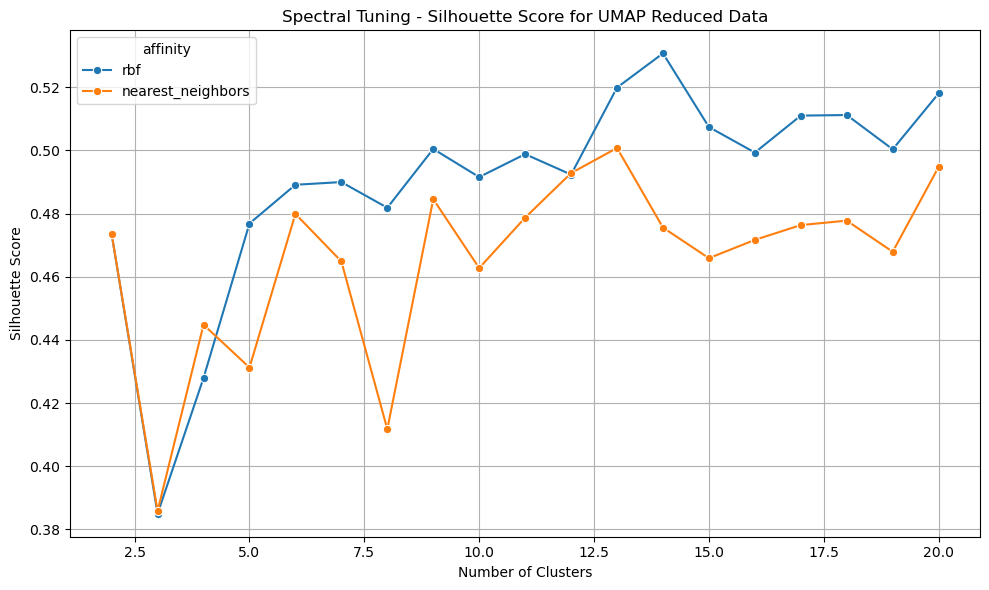

In [212]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=result_df, x='n_clusters', y='silhouette_score', hue='affinity', marker='o')

plt.title('Spectral Tuning - Silhouette Score for UMAP Reduced Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [213]:
description_df['Spectral-Cluster'] = labels

In [214]:
df = df.merge(
    description_df[['Description', 'Spectral-Cluster']],
    left_on='Description',
    right_on='Description',
    how='left'
)

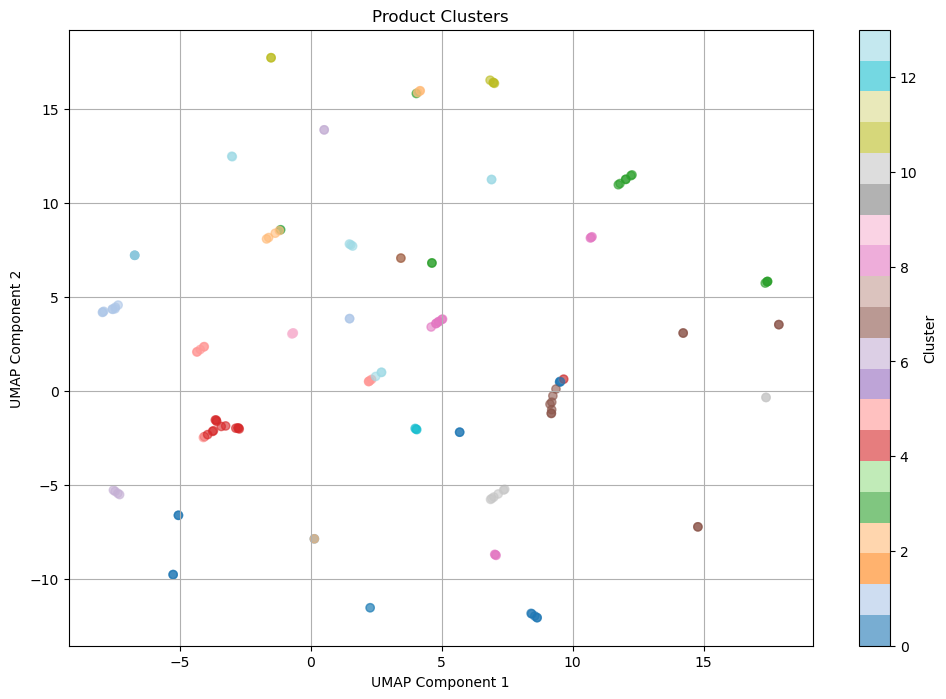

In [215]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.1)
umap_2d = reducer.fit_transform(embeddings)
columns = list(zip(*umap_2d))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(columns[0], columns[1], c=description_df['Spectral-Cluster'].astype(int), cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title('Product Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

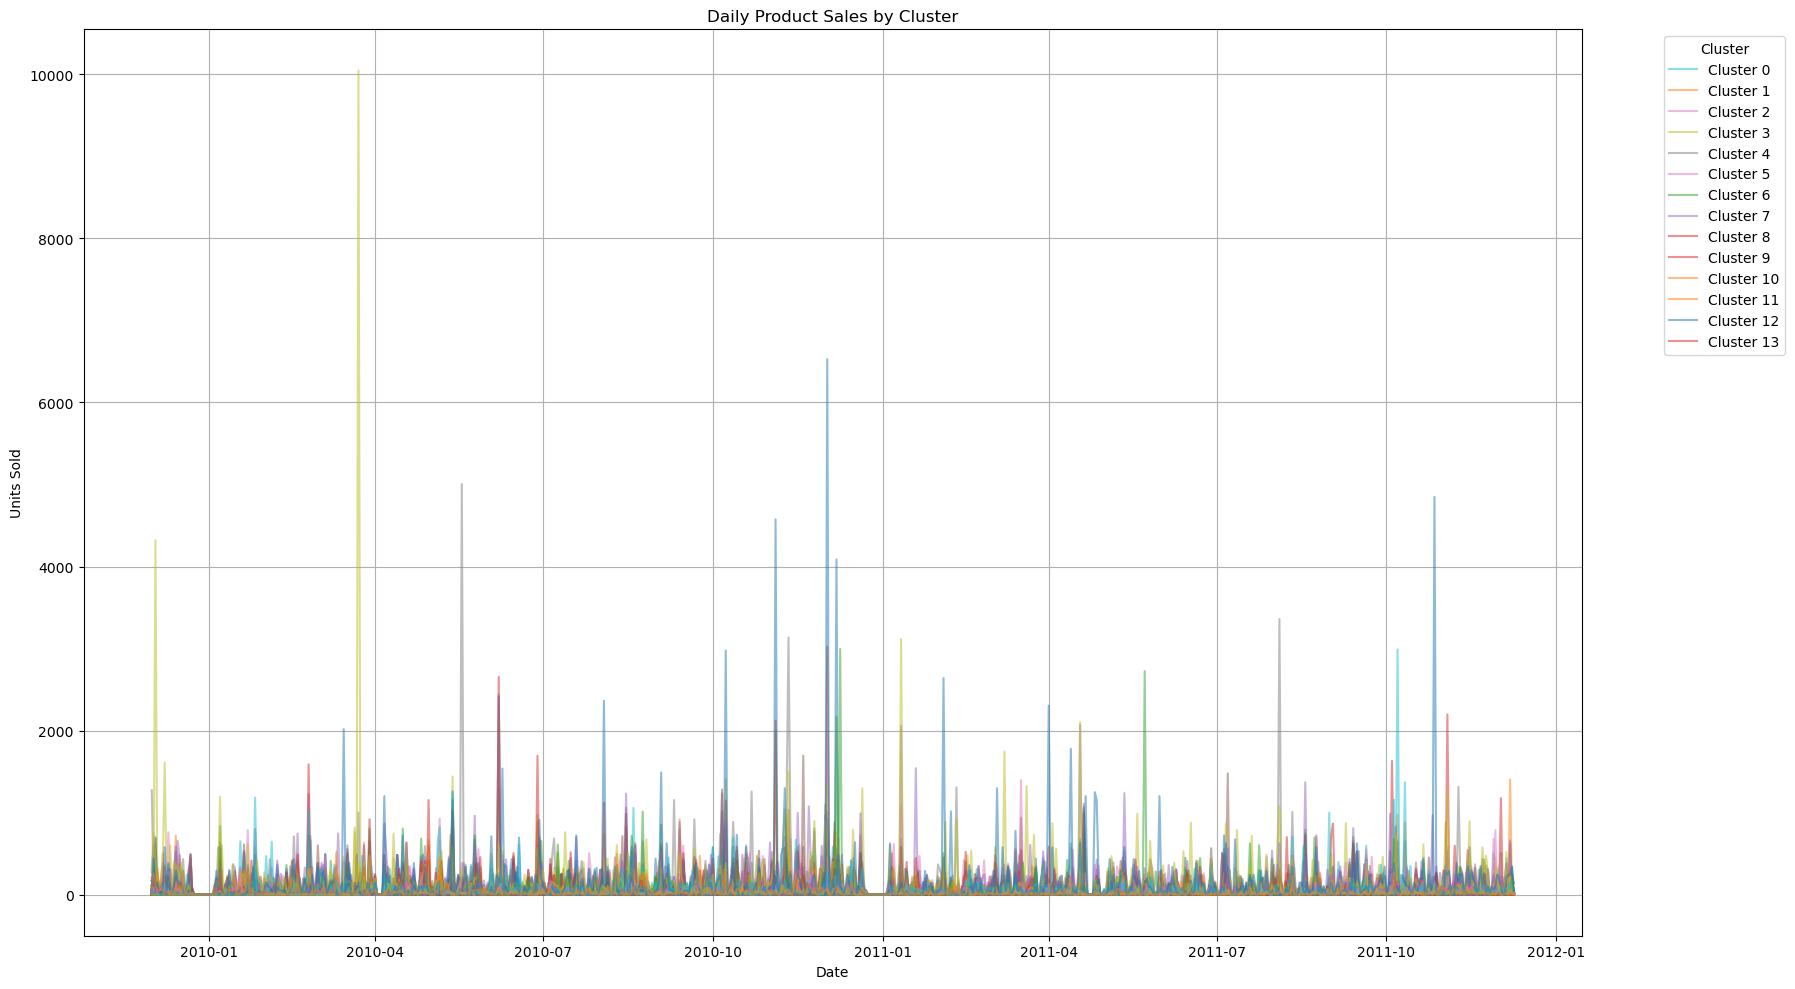

In [216]:
clustered_products = set(df['Description'])
filtered_sales = daily_sales.loc[:, daily_sales.columns.isin(clustered_products)]

plt.figure(figsize=(18, 10))

product_cluster_map = {
    desc: df.loc[df['Description'] == desc, 'Spectral-Cluster'].values[0]
    for desc in filtered_sales.columns
}

plotted_clusters = set()

for product in filtered_sales.columns:
    cluster_id = product_cluster_map[product]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    if label:
        plotted_clusters.add(cluster_id)

    plt.plot(
        filtered_sales.index,
        filtered_sales[product],
        label=label,
        alpha=0.5
    )

# Sort legend entries by cluster number
handles, labels = plt.gca().get_legend_handles_labels()
label_cluster_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]))

sorted_labels, sorted_handles = zip(*label_cluster_pairs)

plt.legend(sorted_handles, sorted_labels, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Daily Product Sales by Cluster")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

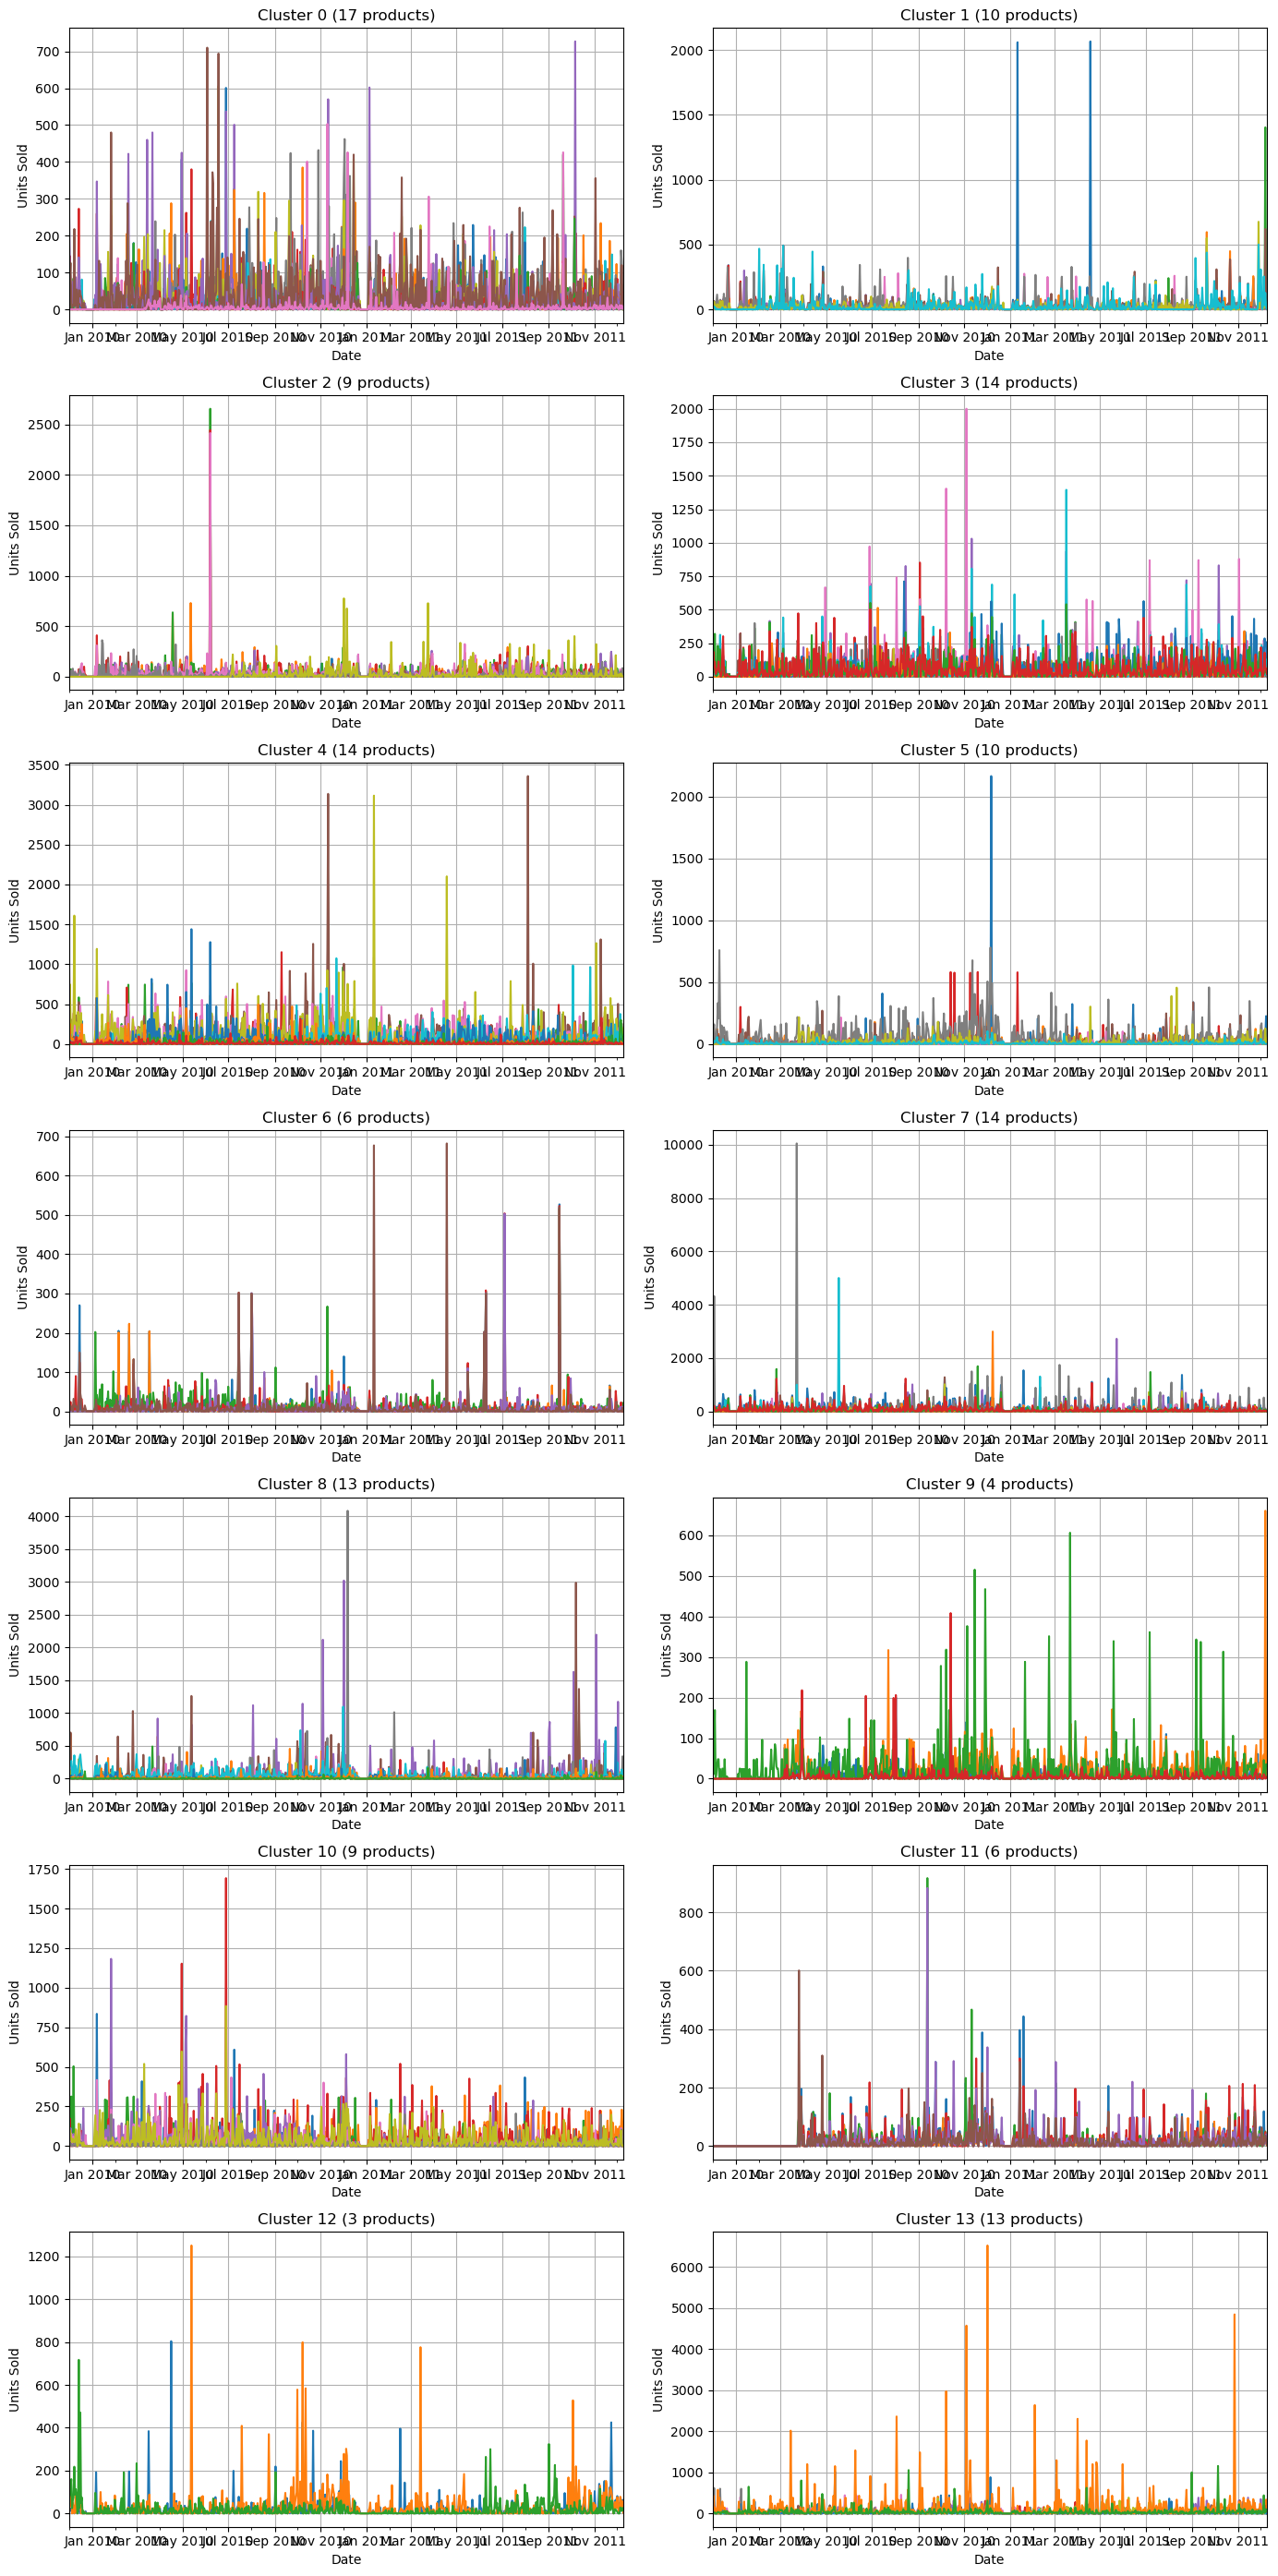

In [217]:
# Ensure date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create pivoted DataFrame: rows = dates, columns = products, values = UnitsSold
units_sold_pivoted_df = df.pivot_table(
    index='Date',
    columns='Description',
    values='UnitsSold',
    aggfunc='sum'
).fillna(0)

# Map each product to its cluster
product_cluster_map = description_df.set_index('Description')['Spectral-Cluster'].to_dict()

# Build cluster list like: clusters = [set(...), set(...), ...]
cluster_ids = sorted(description_df['Spectral-Cluster'].unique())
clusters = [
    set(description for description, cluster in product_cluster_map.items() if cluster == cluster_id)
    for cluster_id in cluster_ids
]

# Plot using subplots (adjust rows/cols as needed)
n_clusters = len(clusters)
ncols = 2
nrows = (n_clusters + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))

# Flatten axs in case of 1 row or 1 column
axs = axs.flatten()

for i, (ax, cluster) in enumerate(zip(axs, clusters)):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i} ({len(cluster)} products)')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units Sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid(True)

# Hide unused subplots if n_clusters < nrows * ncols
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [218]:
clusters = df.groupby('Spectral-Cluster')['Description'].unique()

for cluster_id in sorted(clusters.index):
    print(f"Cluster {cluster_id}:")
    for desc in sorted(clusters[cluster_id]):
        print(f"- {desc}")
    print()

Cluster 0:
- baking set 9 piece retrospot
- baking set spaceboy design
- lunchbox with cutlery retrospot
- memo board retrospot design
- paper bunting retro spots
- paper chain kit retro spot
- recycling bag retrospot
- red retrospot mug
- red spot ceramic drawer knob
- regency cakestand 3 tier
- retro spot cake stand
- retro spot large milk jug
- retro spot small milk jug
- retro spot tea set ceramic 11 pc
- ribbon reel spots design
- set of 72 retro spot paper doilies
- white spot red ceramic drawer knob

Cluster 1:
- bathroom metal sign
- chocolate this way metal sign
- cook with wine metal sign
- gin tonic diet metal sign
- hand over the chocolate sign
- hot baths metal sign
- metal sign take it or leave it
- no singing metal sign
- pottering in the shed metal sign
- toilet metal sign

Cluster 2:
- childs apron spaceboy design
- lunch bag black skull
- lunch bag cars blue
- lunch bag woodland
- lunchbag spaceboy design
- lunchbag suki design
- lunchbox i love london
- skull shoulde

# Save clusters

In [219]:
df.to_csv("../dataset/clustered_data.csv", index=False)

In [220]:
description_df.to_csv("../dataset/description_clusters.csv", index=False)